In [6]:
!pip install torch

   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.1/199.4 MB 787.7 kB/s eta 0:04:14
   ---------------------------------------- 0.2/199.4 MB 1.6 MB/s eta 0:02:08
   ---------------------------------------- 0.5/199.4 MB 2.7 MB/s eta 0:01:15
   ---------------------------------------- 0.5/199.4 MB 2.7 MB/s eta 0:01:13
   ---------------------------------------- 1.0/199.4 MB 3.9 MB/s eta 0:00:52
   ---------------------------------------- 1.5/199.4 MB 4.7 MB/s eta 0:00:43
   ---------------------------------------- 1.8/199.4 MB 4.9 MB/s eta 0:00:41
   ---------------------------------------- 2.2/199.4 MB 5.3 MB/s eta 0:00:38
    --------------------------------------- 2.5/199.4 MB 5.8 MB/s eta 0:00:34
    --------------------------------------- 2.9/199.4 MB 6.0 MB/s eta 0:00:33
    --------------------------------------- 2.9/199.4 MB 6.0 MB/s eta 0:00:3

# Dataset 1


In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # For 3D surface plot
from matplotlib import cm  # For color maps

# Define the Multilayer Feedforward Neural Network (MLFFNN)
class MLFFNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):
        super(MLFFNN, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.Tanh())
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_layers[-1], output_size))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Function to train the network and capture training loss
def train_model(model, criterion, optimizer, train_loader, epochs=100):
    model.train()
    losses = []  # To store loss for each epoch
    
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)  # Append loss for plotting
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')
    
    return losses  # Return losses for the training error vs. epoch plot

# Function to plot training error vs. epoch
def plot_training_error(losses):
    plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
    # Set line style, color, and marker options
    plt.plot(range(1, len(losses) + 1), losses, label='Training Error', color='blue', marker='o', linestyle='-', markersize=3, linewidth=1)
    plt.xlabel('Epoch')
    plt.ylabel('Training Error (६av)')
    plt.title('Training Error vs. Epoch')
    plt.grid(True)  # Add grid lines
    plt.legend()
    plt.show()

# Function to scatter plot training and test data with predictions, regression line, and fit line
def scatter_plot_data(model, X_train, y_train, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train).detach().numpy()
        y_test_pred = model(X_test).detach().numpy()
    
    # Scatter plot for training data with regression line (y = x) and best-fit line
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train.flatten(), y_train_pred.flatten(), label='Train Data', color='blue', alpha=0.6)
    
    # Ideal fit line (y = x)
    min_val = min(y_train.min(), y_train_pred.min())  # Get the minimum value for the line
    max_val = max(y_train.max(), y_train_pred.max())  # Get the maximum value for the line
    plt.plot([min_val, max_val], [min_val, max_val], color='red', label='Ideal Fit (y=x)', linestyle='--')
    
    # Predicted fit line using polyfit (degree 1 for linear fit)
    slope, intercept = np.polyfit(y_train.flatten(), y_train_pred.flatten(), 1)
    y_pred_fit = slope * np.array([min_val, max_val]) + intercept
    plt.plot([min_val, max_val], y_pred_fit, color='green', label='Predicted Fit Line (Train)', linestyle='-')

    plt.xlabel('True Output')
    plt.ylabel('Predicted Output')
    plt.title('Training Data: True vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Scatter plot for test data with regression line (y = x) and best-fit line
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test.flatten(), y_test_pred.flatten(), label='Test Data', color='green', alpha=0.6)
    
    # Ideal fit line (y = x)
    min_val = min(y_test.min(), y_test_pred.min())  # Get the minimum value for the line
    max_val = max(y_test.max(), y_test_pred.max())  # Get the maximum value for the line
    plt.plot([min_val, max_val], [min_val, max_val], color='red', label='Ideal Fit (y=x)', linestyle='--')
    
    # Predicted fit line for test data using polyfit (degree 1 for linear fit)
    slope_test, intercept_test = np.polyfit(y_test.flatten(), y_test_pred.flatten(), 1)
    y_test_fit = slope_test * np.array([min_val, max_val]) + intercept_test
    plt.plot([min_val, max_val], y_test_fit, color='orange', label='Predicted Fit Line (Test)', linestyle='-')

    plt.xlabel('True Output')
    plt.ylabel('Predicted Output')
    plt.title('Test Data: True vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()

    
# Function to plot surface plots for two hidden nodes and the output
def plot_surface(model, X, epoch, node_idx=[0, 1], grid_size=100):
    model.eval()
    
    # Generate a mesh grid over the input space
    x1_min, x1_max = X[:, 0].min().item(), X[:, 0].max().item()
    x2_min, x2_max = X[:, 1].min().item(), X[:, 1].max().item()
    x1_grid, x2_grid = np.meshgrid(np.linspace(x1_min, x1_max, grid_size),
                                   np.linspace(x2_min, x2_max, grid_size))
    
    # Flatten the grid and create input tensor
    grid_input = np.c_[x1_grid.ravel(), x2_grid.ravel()]
    grid_input_tensor = torch.tensor(grid_input, dtype=torch.float32)
    
    # Get the activations of the hidden layers and the output node
    with torch.no_grad():
        hidden_activations = model.network[:-1](grid_input_tensor).detach().numpy()  # Hidden layer activations
        output_activations = model(grid_input_tensor).detach().numpy()  # Output layer activations
    
    # Reshape activations to match the grid
    hidden_activations_1 = hidden_activations[:, node_idx[0]].reshape(x1_grid.shape)
    hidden_activations_2 = hidden_activations[:, node_idx[1]].reshape(x1_grid.shape)
    output_activations = output_activations.reshape(x1_grid.shape)
    
    # Create the 3D surface plot for the hidden nodes
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(x1_grid, x2_grid, hidden_activations_1, cmap=cm.coolwarm)
    ax.set_title(f'Hidden Node {node_idx[0]} Activations (Epoch {epoch})')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel(f'Activation Node {node_idx[0]}')

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(x1_grid, x2_grid, hidden_activations_2, cmap=cm.coolwarm)
    ax2.set_title(f'Hidden Node {node_idx[1]} Activations (Epoch {epoch})')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_zlabel(f'Activation Node {node_idx[1]}')

    # Create another figure for output node surface
    fig2 = plt.figure(figsize=(8, 6))
    ax3 = fig2.add_subplot(111, projection='3d')
    ax3.plot_surface(x1_grid, x2_grid, output_activations, cmap=cm.viridis)
    ax3.set_title(f'Output Node Activation (Epoch {epoch})')
    ax3.set_xlabel('X1')
    ax3.set_ylabel('X2')
    ax3.set_zlabel('Output')
    
    plt.show()

# # Surface plot for hidden nodes and output after 1, 10, 50, and final epoch
# for epoch in [1, 10, 50, 100]:
#     plot_surface(model, X_train, epoch)

# Function to load and normalize the data
def load_and_normalize_data(train_file_path, test_file_path):
    train_data = pd.read_csv(train_file_path)
    test_data = pd.read_csv(test_file_path)
    
    X_train = train_data[['x1', 'x2']].values
    y_train = train_data['output'].values
    
    X_test = test_data[['x1', 'x2']].values
    y_test = test_data['output'].values
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train = scaler_X.fit_transform(X_train)
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    
    X_test = scaler_X.transform(X_test)
    y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor


Epoch [1/100], Loss: 0.927829
Epoch [2/100], Loss: 1.030155
Epoch [3/100], Loss: 0.371651
Epoch [4/100], Loss: 0.922692
Epoch [5/100], Loss: 0.593518
Epoch [6/100], Loss: 0.521299
Epoch [7/100], Loss: 0.427927
Epoch [8/100], Loss: 0.362949
Epoch [9/100], Loss: 0.468479
Epoch [10/100], Loss: 0.343643
Epoch [11/100], Loss: 0.594253
Epoch [12/100], Loss: 0.245625
Epoch [13/100], Loss: 0.469510
Epoch [14/100], Loss: 0.266423
Epoch [15/100], Loss: 0.275293
Epoch [16/100], Loss: 0.372998
Epoch [17/100], Loss: 0.211341
Epoch [18/100], Loss: 0.169252
Epoch [19/100], Loss: 0.198465
Epoch [20/100], Loss: 0.132003
Epoch [21/100], Loss: 0.112698
Epoch [22/100], Loss: 0.147254
Epoch [23/100], Loss: 0.177840
Epoch [24/100], Loss: 0.116182
Epoch [25/100], Loss: 0.149345
Epoch [26/100], Loss: 0.195112
Epoch [27/100], Loss: 0.089989
Epoch [28/100], Loss: 0.196196
Epoch [29/100], Loss: 0.105759
Epoch [30/100], Loss: 0.218121
Epoch [31/100], Loss: 0.175615
Epoch [32/100], Loss: 0.280966
Epoch [33/100], L

C:\Users\arist\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2412 (\N{DEVANAGARI DIGIT SIX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\arist\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


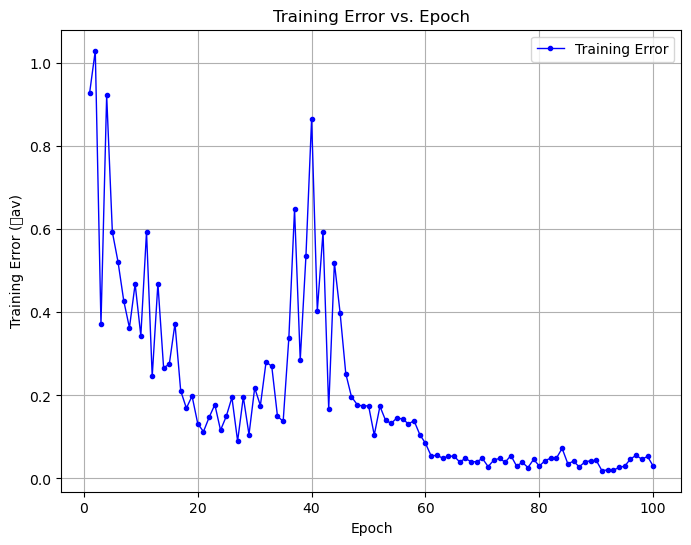

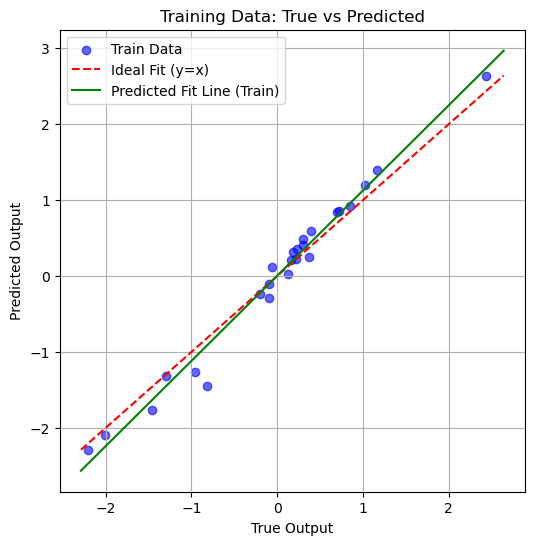

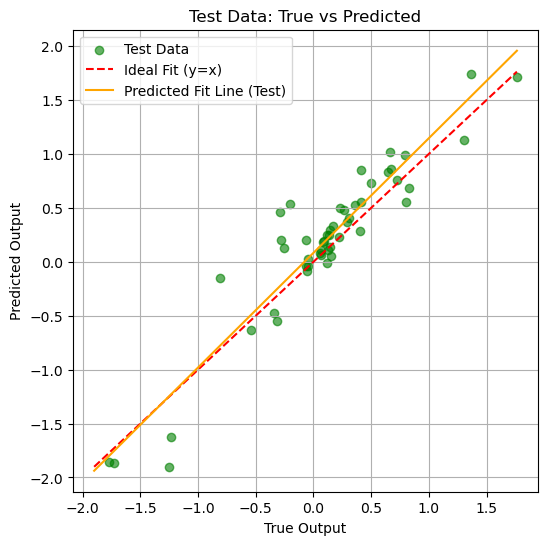

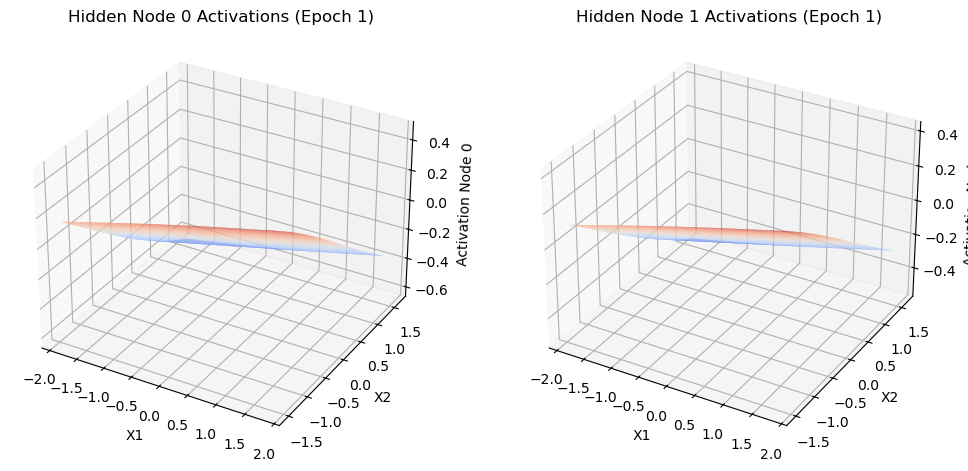

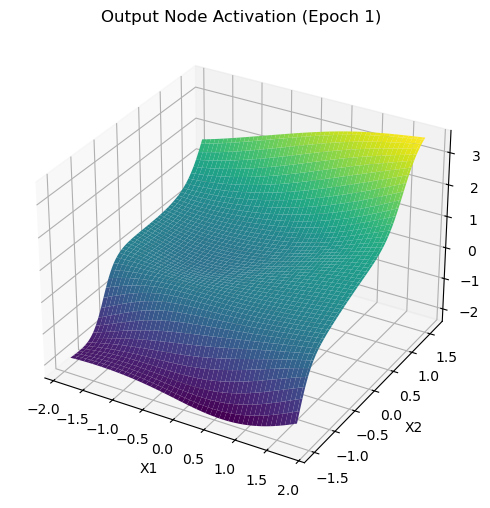

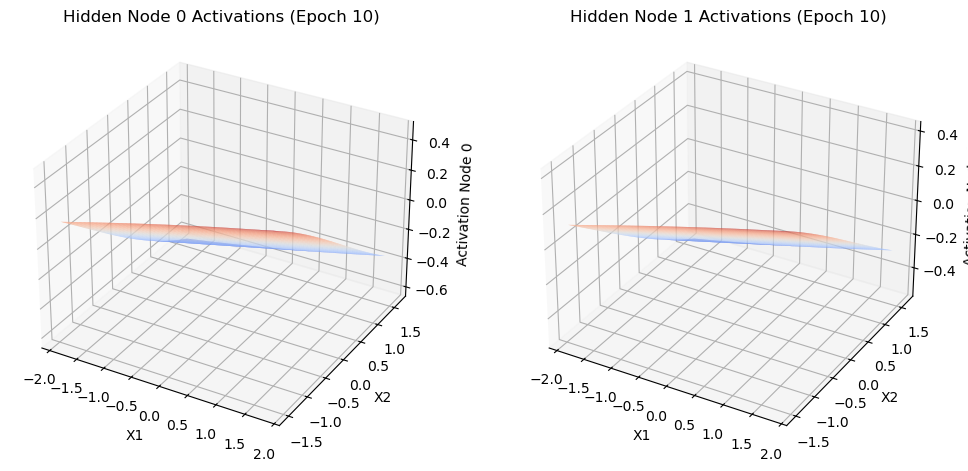

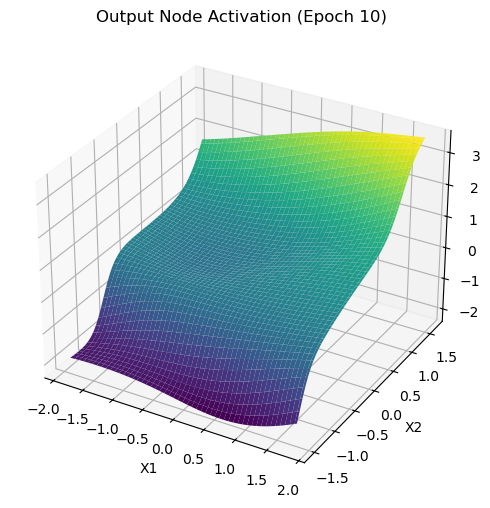

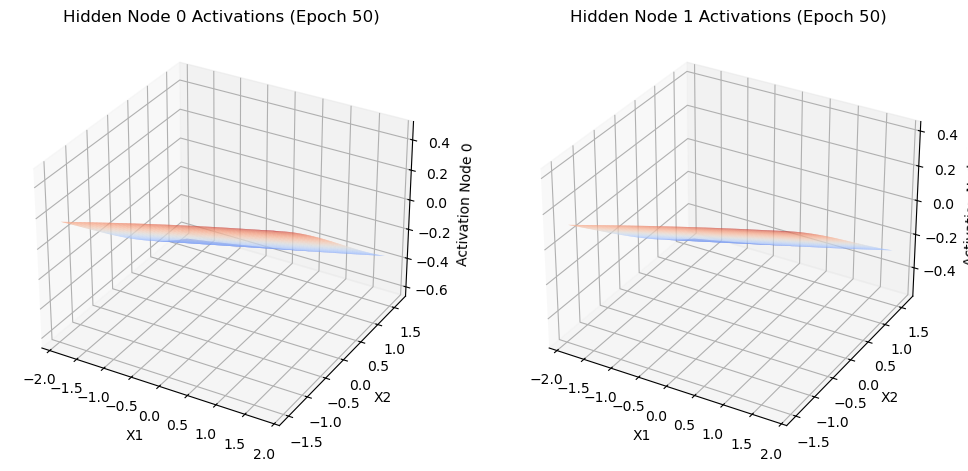

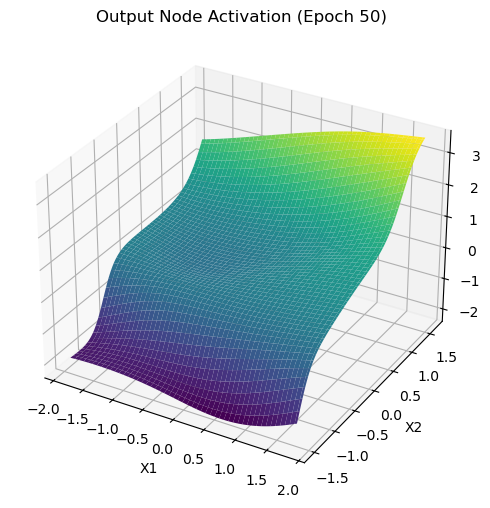

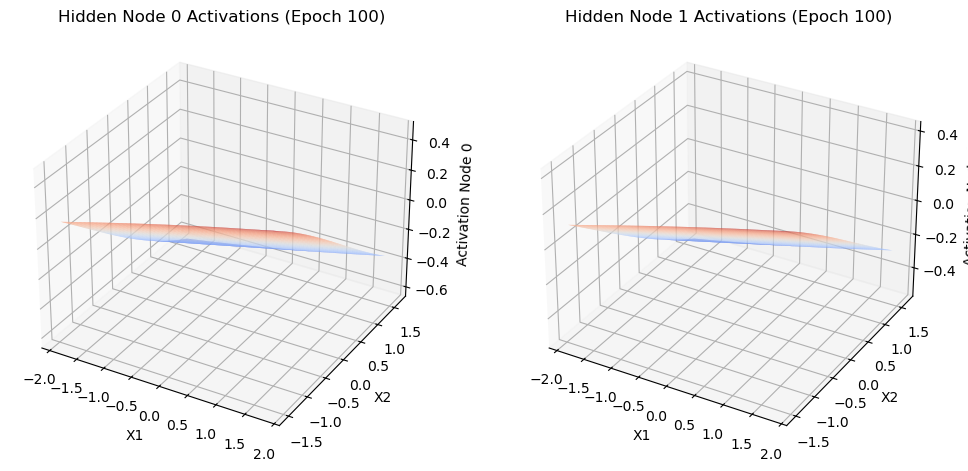

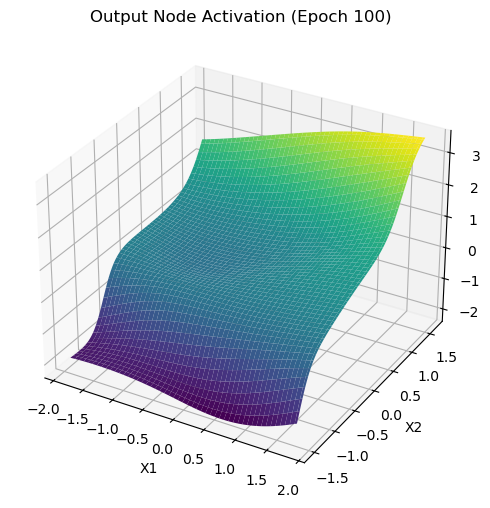

In [163]:

# Hyperparameters
input_size = 2  # Two input features (x1, x2)
output_size = 1  # Single output (function approximation)
hidden_layers = [8]  # Example: 1 hidden layer with 8 nodes
learning_rate = 0.2

# Create the model
model = MLFFNN(input_size, output_size, hidden_layers)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for function approximation
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# File paths for your dataset
train_file_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D1_dataset2a_1\Train-2a-25.csv"
test_file_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D1_dataset2a_1\Test-50.csv"

# Load and normalize the data
X_train, y_train, X_test, y_test = load_and_normalize_data(train_file_path, test_file_path)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Train the model
losses = train_model(model, criterion, optimizer, train_loader, epochs=100)

# Plot the training error vs. epoch
plot_training_error(losses)

# Scatter plot the training and test data with predictions
scatter_plot_data(model, X_train, y_train, X_test, y_test)

# Surface plot for hidden nodes and output after 1, 10, 50, and final epoch
for epoch in [1, 10, 50, 100]:
    plot_surface(model, X_train, epoch)


Epoch [1/100], Loss: 1.192725
Epoch [2/100], Loss: 0.552251
Epoch [3/100], Loss: 0.405980
Epoch [4/100], Loss: 0.459220
Epoch [5/100], Loss: 0.673359
Epoch [6/100], Loss: 0.418943
Epoch [7/100], Loss: 0.509046
Epoch [8/100], Loss: 0.370600
Epoch [9/100], Loss: 0.474235
Epoch [10/100], Loss: 0.345924
Epoch [11/100], Loss: 0.302076
Epoch [12/100], Loss: 0.313800
Epoch [13/100], Loss: 0.206195
Epoch [14/100], Loss: 0.265416
Epoch [15/100], Loss: 0.241794
Epoch [16/100], Loss: 0.213521
Epoch [17/100], Loss: 0.217406
Epoch [18/100], Loss: 0.224352
Epoch [19/100], Loss: 0.197126
Epoch [20/100], Loss: 0.252808
Epoch [21/100], Loss: 0.239020
Epoch [22/100], Loss: 0.205326
Epoch [23/100], Loss: 0.218101
Epoch [24/100], Loss: 0.187066
Epoch [25/100], Loss: 0.221597
Epoch [26/100], Loss: 0.193701
Epoch [27/100], Loss: 0.192188
Epoch [28/100], Loss: 0.184744
Epoch [29/100], Loss: 0.184762
Epoch [30/100], Loss: 0.154256
Epoch [31/100], Loss: 0.168231
Epoch [32/100], Loss: 0.174536
Epoch [33/100], L

C:\Users\arist\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2412 (\N{DEVANAGARI DIGIT SIX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\arist\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


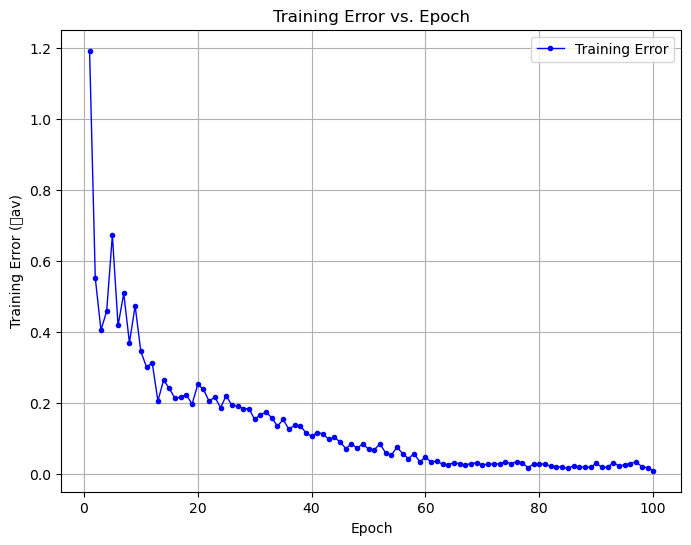

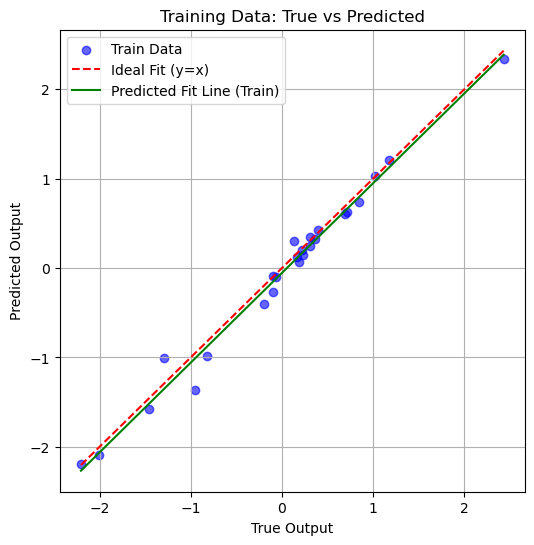

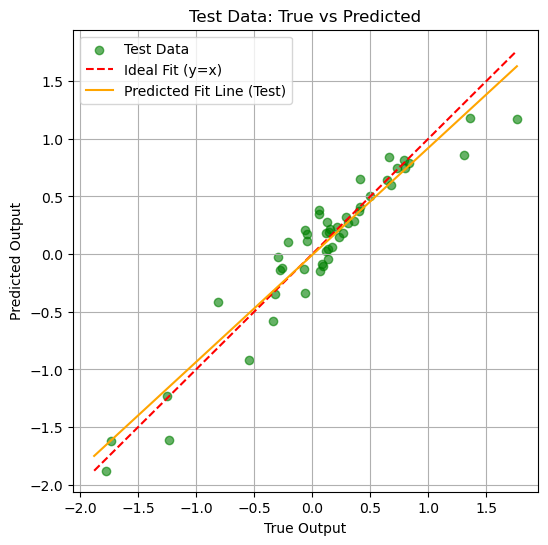

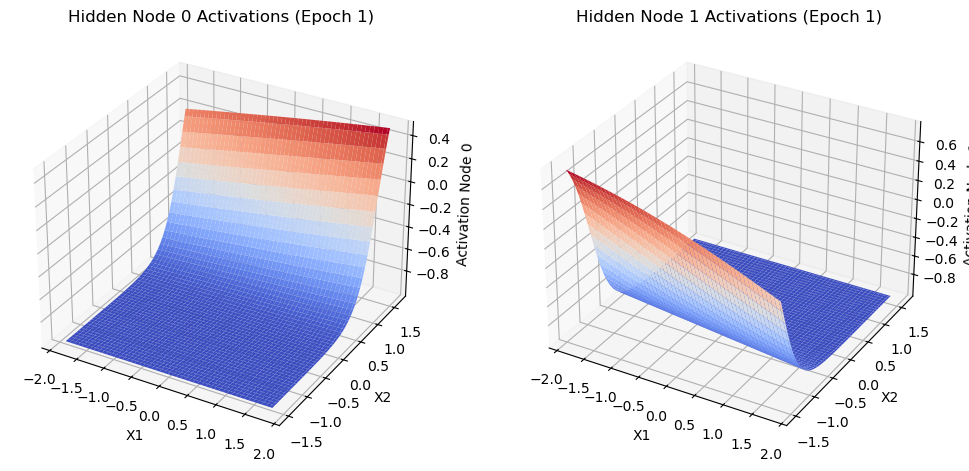

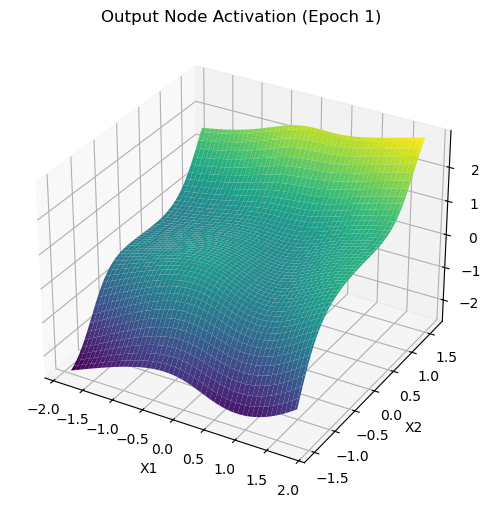

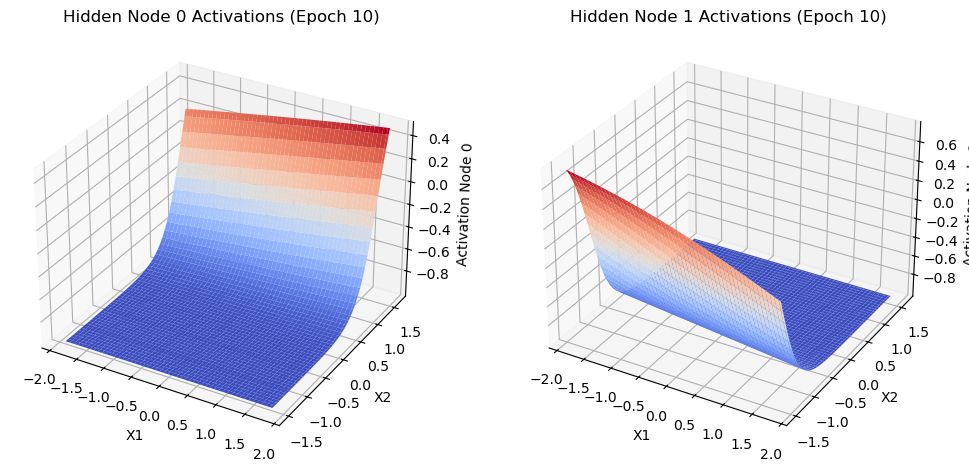

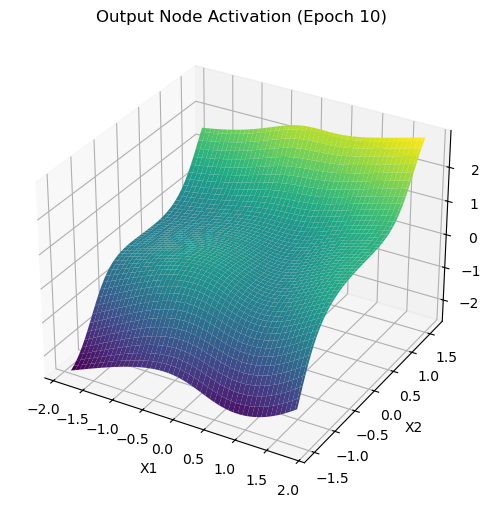

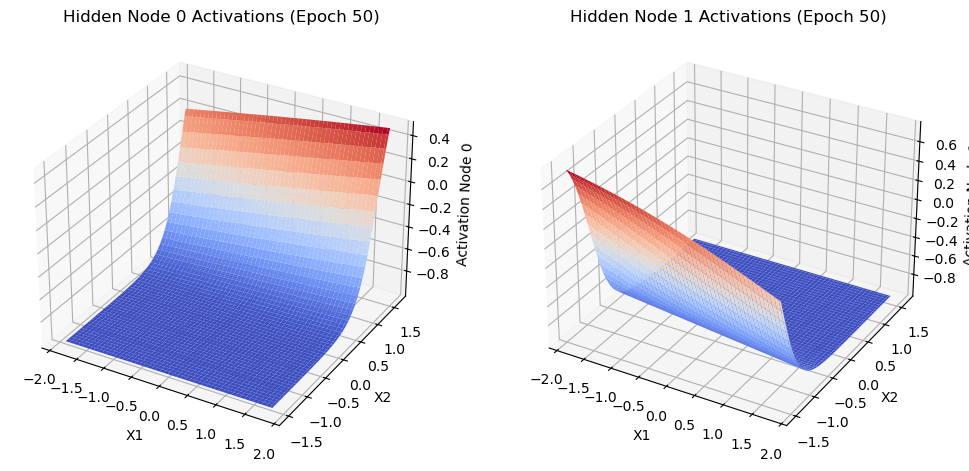

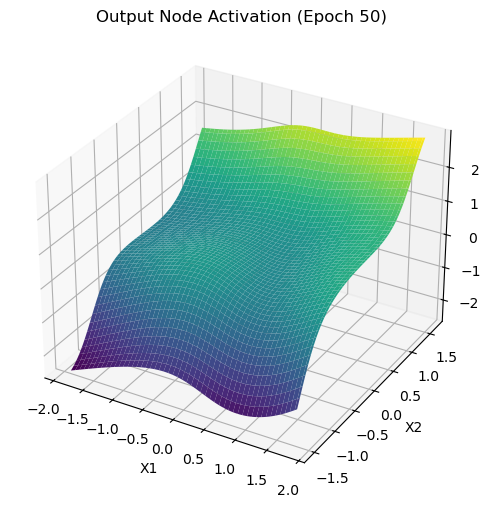

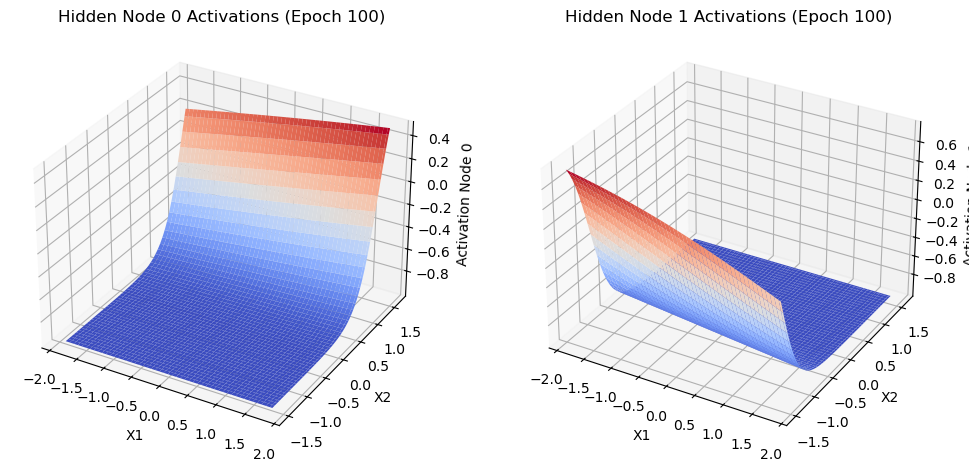

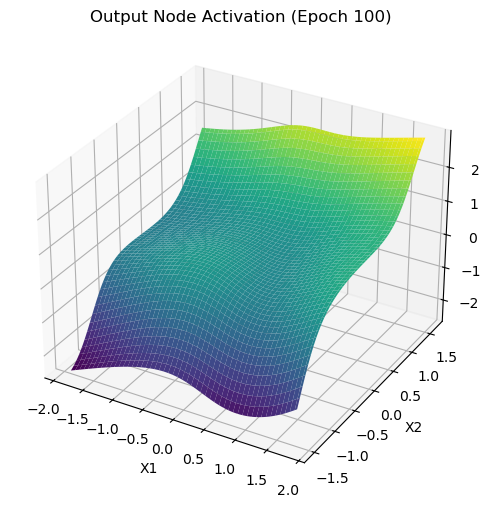

In [165]:

# Hyperparameters
input_size = 2  # Two input features (x1, x2)
output_size = 1  # Single output (function approximation)
hidden_layers = [8]  # Example: 1 hidden layer with 8 nodes
learning_rate = 0.1

# Create the model
model = MLFFNN(input_size, output_size, hidden_layers)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for function approximation
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# File paths for your dataset
train_file_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D1_dataset2a_1\Train-2a-25.csv"
test_file_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D1_dataset2a_1\Test-50.csv"

# Load and normalize the data
X_train, y_train, X_test, y_test = load_and_normalize_data(train_file_path, test_file_path)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Train the model
losses = train_model(model, criterion, optimizer, train_loader, epochs=100)

# Plot the training error vs. epoch
plot_training_error(losses)

# Scatter plot the training and test data with predictions
scatter_plot_data(model, X_train, y_train, X_test, y_test)

# Surface plot for hidden nodes and output after 1, 10, 50, and final epoch
for epoch in [1, 10, 50, 100]:
    plot_surface(model, X_train, epoch)


Epoch [1/100], Loss: 1.202517
Epoch [2/100], Loss: 0.695663
Epoch [3/100], Loss: 1.000882
Epoch [4/100], Loss: 7.850128
Epoch [5/100], Loss: 133.919800
Epoch [6/100], Loss: 16522.874268
Epoch [7/100], Loss: 9031211.687500
Epoch [8/100], Loss: 2558434944.000000
Epoch [9/100], Loss: 1353690316800.000000
Epoch [10/100], Loss: 971960385273856.000000
Epoch [11/100], Loss: 594979126570385408.000000
Epoch [12/100], Loss: 460310594645468905472.000000
Epoch [13/100], Loss: 569989790081733302943744.000000
Epoch [14/100], Loss: 483432153662289053092937728.000000
Epoch [15/100], Loss: 222575414110071206856533999616.000000
Epoch [16/100], Loss: 155178595885878841086065588043776.000000
Epoch [17/100], Loss: 215130586712816755231793296279863296.000000
Epoch [18/100], Loss: inf
Epoch [19/100], Loss: inf
Epoch [20/100], Loss: nan
Epoch [21/100], Loss: nan
Epoch [22/100], Loss: nan
Epoch [23/100], Loss: nan
Epoch [24/100], Loss: nan
Epoch [25/100], Loss: nan
Epoch [26/100], Loss: nan
Epoch [27/100], Los

C:\Users\arist\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2412 (\N{DEVANAGARI DIGIT SIX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\arist\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


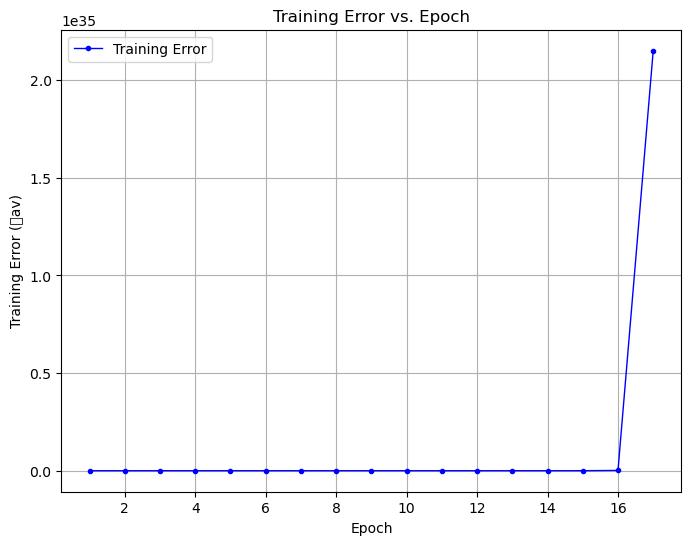

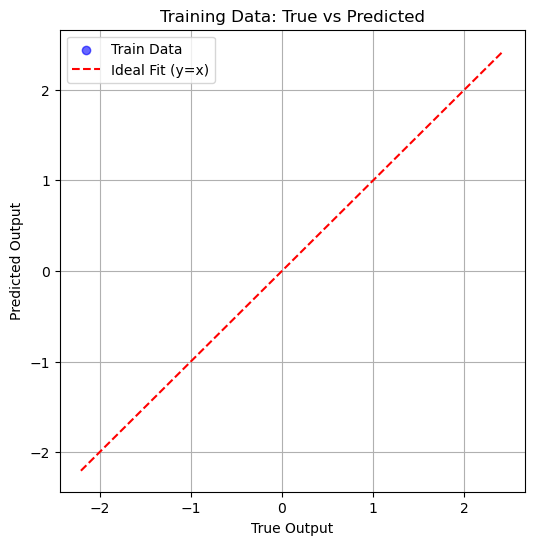

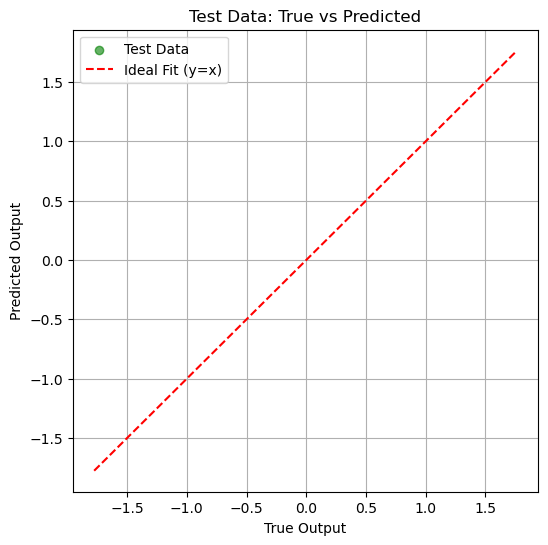

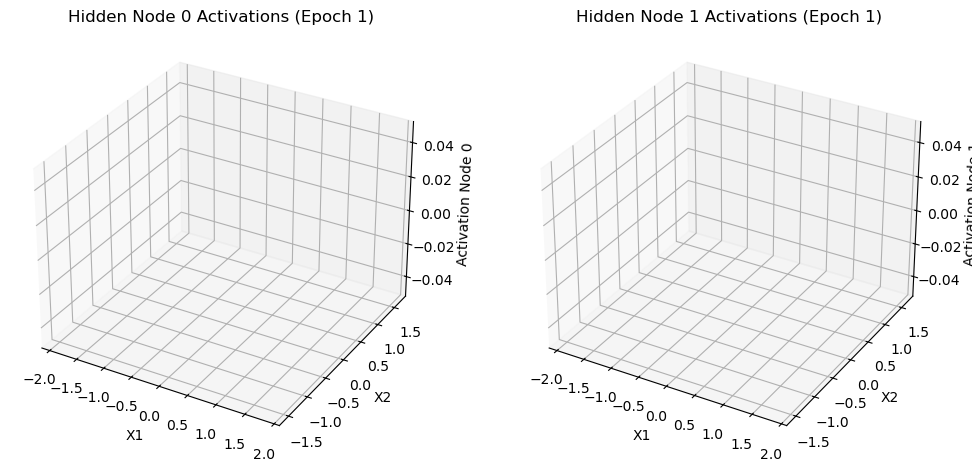

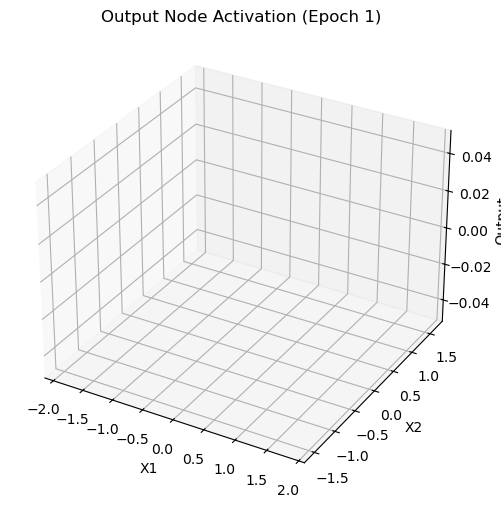

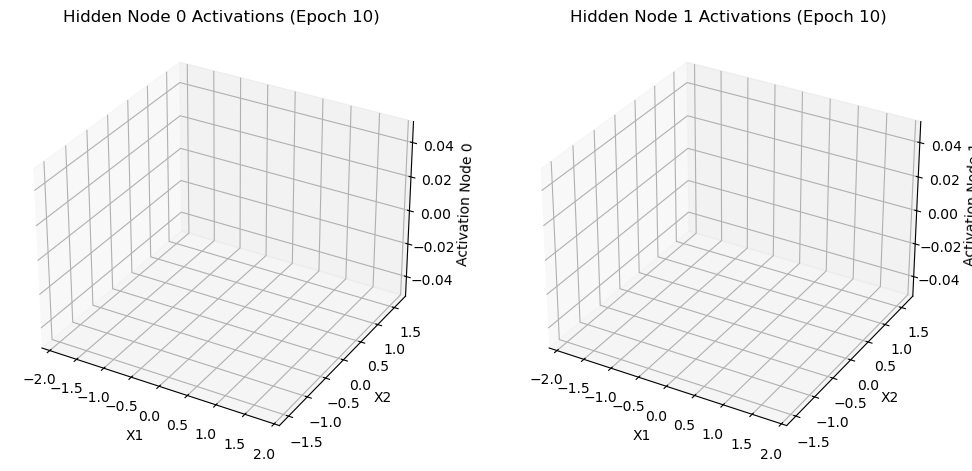

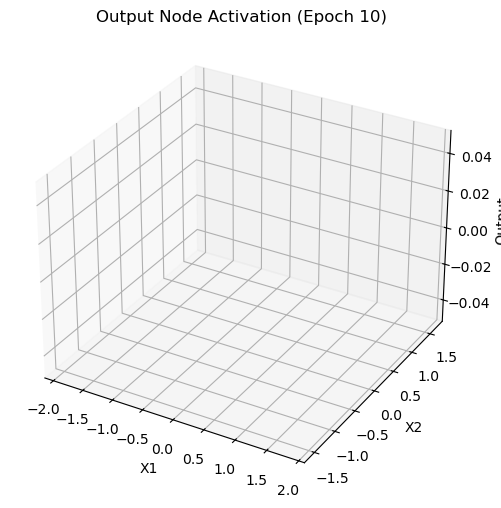

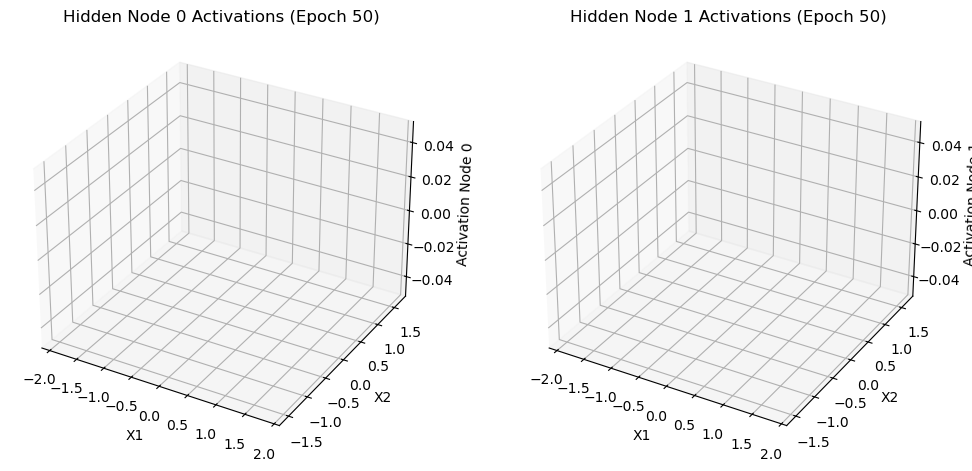

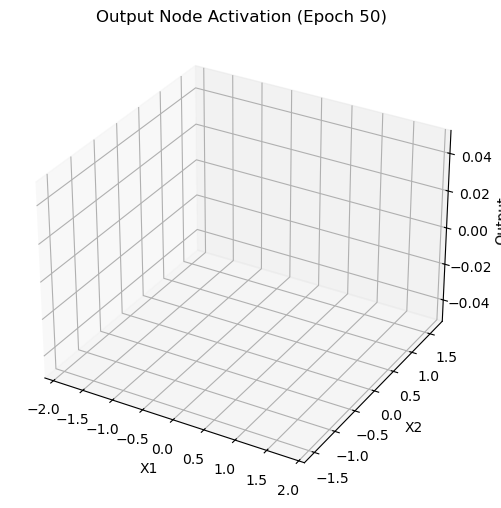

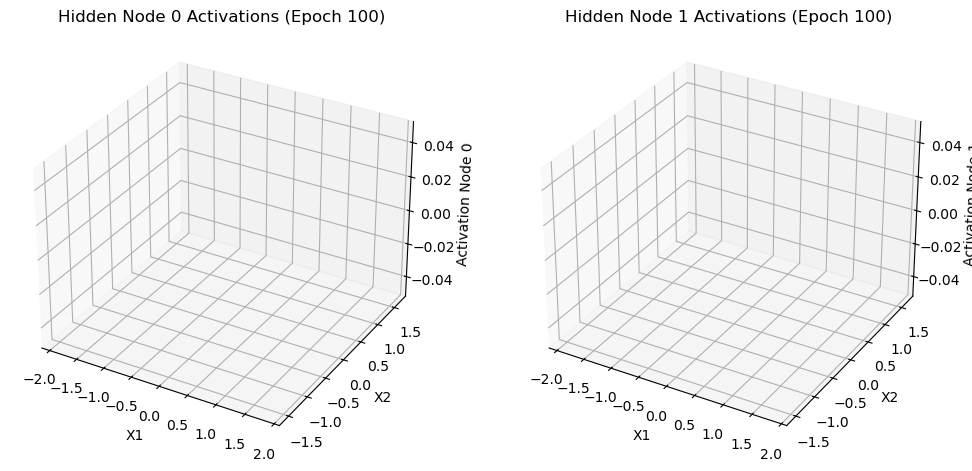

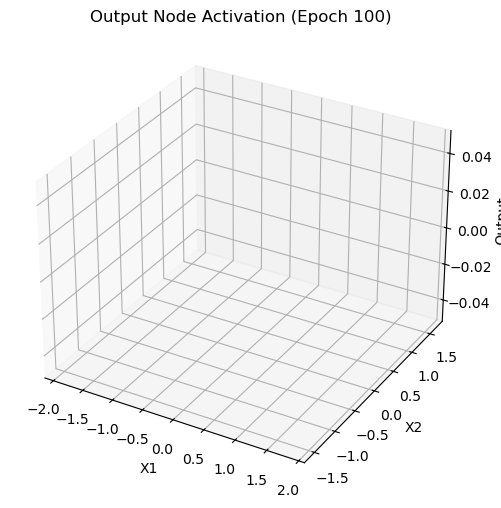

In [92]:

# Hyperparameters
input_size = 2  # Two input features (x1, x2)
output_size = 1  # Single output (function approximation)
hidden_layers = [8]  # Example: 1 hidden layer with 8 nodes
learning_rate = 0.7

# Create the model
model = MLFFNN(input_size, output_size, hidden_layers)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for function approximation
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# File paths for your dataset
train_file_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D1_dataset2a_1\Train-2a-25.csv"
test_file_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D1_dataset2a_1\Test-50.csv"

# Load and normalize the data
X_train, y_train, X_test, y_test = load_and_normalize_data(train_file_path, test_file_path)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Train the model
losses = train_model(model, criterion, optimizer, train_loader, epochs=100)

# Plot the training error vs. epoch
plot_training_error(losses)

# Scatter plot the training and test data with predictions
scatter_plot_data(model, X_train, y_train, X_test, y_test)

# Surface plot for hidden nodes and output after 1, 10, 50, and final epoch
for epoch in [1, 10, 50, 100]:
    plot_surface(model, X_train, epoch)


# Dataset 2

In [171]:
def load_and_normalize_data(train_data_path, train_label_path, test_data_path, test_label_path):
    # Load the train and test data
    train_data = pd.read_csv(train_data_path, header=None)
    train_labels = pd.read_csv(train_label_path, header=None)
    
    test_data = pd.read_csv(test_data_path, header=None)
    test_labels = pd.read_csv(test_label_path, header=None)
    
    # Normalize input data using StandardScaler
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train = scaler_X.fit_transform(train_data.values)
    y_train = scaler_y.fit_transform(train_labels.values.reshape(-1, 1)).ravel()
    
    X_test = scaler_X.transform(test_data.values)
    y_test = scaler_y.transform(test_labels.values.reshape(-1, 1)).ravel()
    
    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make y 2D for MSE loss
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    
    # Print shapes for debugging
    print(f'X_train shape: {X_train_tensor.shape}, y_train shape: {y_train_tensor.shape}')
    print(f'X_test shape: {X_test_tensor.shape}, y_test shape: {y_test_tensor.shape}')
    
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor



X_train shape: torch.Size([1524, 3]), y_train shape: torch.Size([1524, 1])
X_test shape: torch.Size([436, 3]), y_test shape: torch.Size([436, 1])
Epoch [1/100], Loss: 1.141307
Epoch [2/100], Loss: 1.112623
Epoch [3/100], Loss: 1.114850
Epoch [4/100], Loss: 1.089691
Epoch [5/100], Loss: 1.056441
Epoch [6/100], Loss: 1.097984
Epoch [7/100], Loss: 1.165796
Epoch [8/100], Loss: 1.072171
Epoch [9/100], Loss: 1.063322
Epoch [10/100], Loss: 1.115008
Epoch [11/100], Loss: 1.126463
Epoch [12/100], Loss: 1.110306
Epoch [13/100], Loss: 1.050696
Epoch [14/100], Loss: 1.060620
Epoch [15/100], Loss: 1.093627
Epoch [16/100], Loss: 1.077431
Epoch [17/100], Loss: 1.064215
Epoch [18/100], Loss: 1.118925
Epoch [19/100], Loss: 1.120145
Epoch [20/100], Loss: 1.030128
Epoch [21/100], Loss: 1.053774
Epoch [22/100], Loss: 1.072269
Epoch [23/100], Loss: 1.073686
Epoch [24/100], Loss: 1.034027
Epoch [25/100], Loss: 1.041419
Epoch [26/100], Loss: 1.138807
Epoch [27/100], Loss: 1.050242
Epoch [28/100], Loss: 1.05

C:\Users\arist\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2412 (\N{DEVANAGARI DIGIT SIX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\arist\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


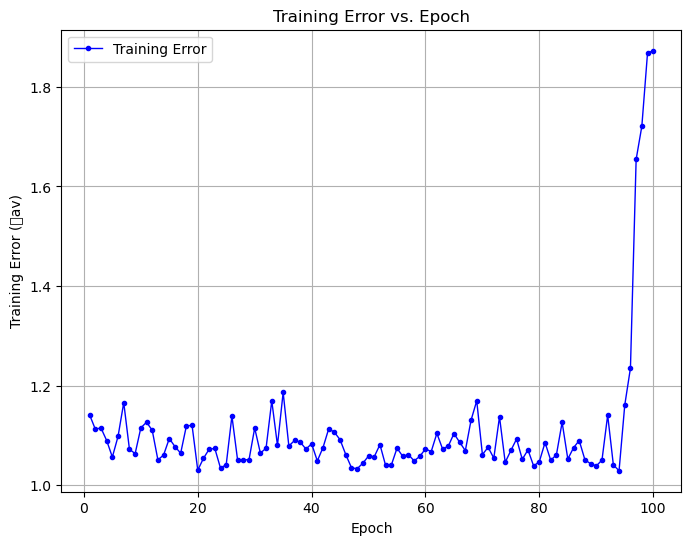

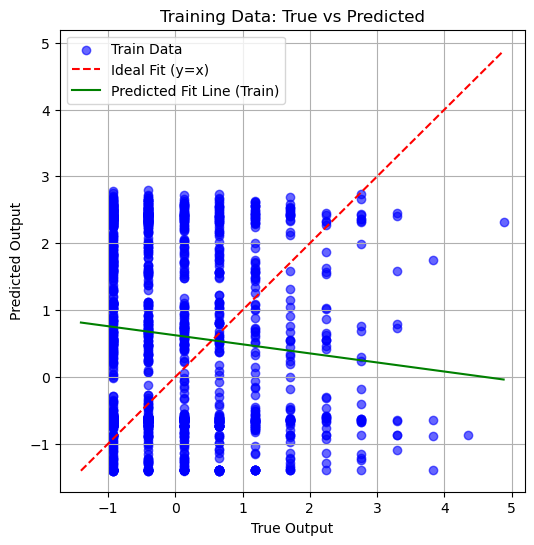

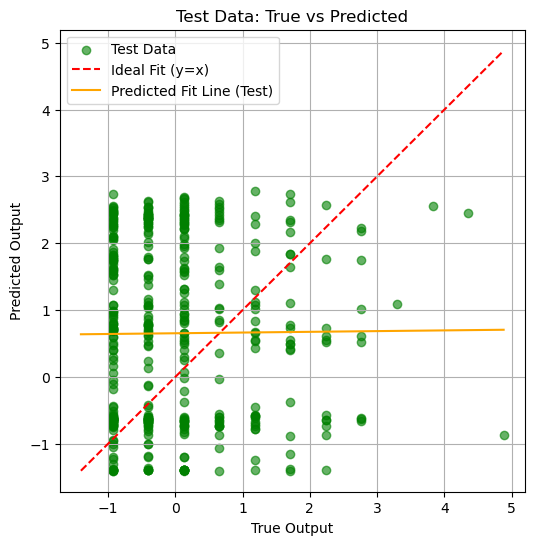

In [177]:

# Hyperparameters
# Hyperparameters
input_size = 3  # Two input features (x1, x2)
output_size = 1  # Single output (function approximation)
hidden_layers = [15,10]  # Example: 1 hidden layer with 8 nodes
learning_rate = 0.01

# Create the model
model = MLFFNN(input_size, output_size, hidden_layers)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for function approximation
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# File paths for your dataset
train_data_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D2_dataset3_1\train_data.csv"
train_label_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D2_dataset3_1\train_label.csv"
test_data_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D2_dataset3_1\test_data.csv"
test_label_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D2_dataset3_1\test_label.csv"

# Load and normalize the data
X_train, y_train, X_test, y_test = load_and_normalize_data(train_data_path, train_label_path, test_data_path, test_label_path)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Train the model
losses = train_model(model, criterion, optimizer, train_loader, epochs=100)

# Plot the training error vs. epoch
plot_training_error(losses)

# Scatter plot the training and test data with predictions
scatter_plot_data(model, X_train, y_train, X_test, y_test)



X_train shape: torch.Size([1524, 3]), y_train shape: torch.Size([1524, 1])
X_test shape: torch.Size([436, 3]), y_test shape: torch.Size([436, 1])
Epoch [1/100], Loss: 3.185947
Epoch [2/100], Loss: 8.299791
Epoch [3/100], Loss: 6.101172
Epoch [4/100], Loss: 15.605782
Epoch [5/100], Loss: 18.918683
Epoch [6/100], Loss: 218.974051
Epoch [7/100], Loss: 23.298073
Epoch [8/100], Loss: 16.334842
Epoch [9/100], Loss: 16.317433
Epoch [10/100], Loss: 53.752300
Epoch [11/100], Loss: 62.796229
Epoch [12/100], Loss: 35.487676
Epoch [13/100], Loss: 226.112105
Epoch [14/100], Loss: 38.762615
Epoch [15/100], Loss: 5.738976
Epoch [16/100], Loss: 5.828180
Epoch [17/100], Loss: 27.424134
Epoch [18/100], Loss: 33.710296
Epoch [19/100], Loss: 58.094972
Epoch [20/100], Loss: 101.484467
Epoch [21/100], Loss: 10.939000
Epoch [22/100], Loss: 15.782414
Epoch [23/100], Loss: 200.033598
Epoch [24/100], Loss: 95.121424
Epoch [25/100], Loss: 103.978018
Epoch [26/100], Loss: 34.876671
Epoch [27/100], Loss: 40.714268

C:\Users\arist\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2412 (\N{DEVANAGARI DIGIT SIX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\arist\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


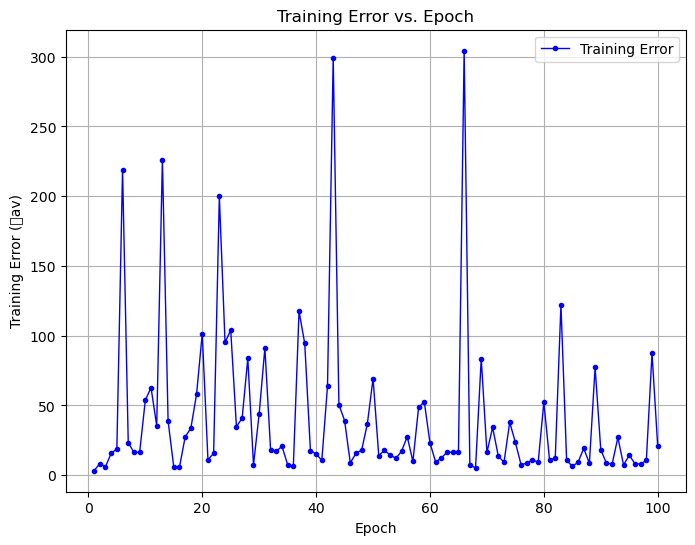

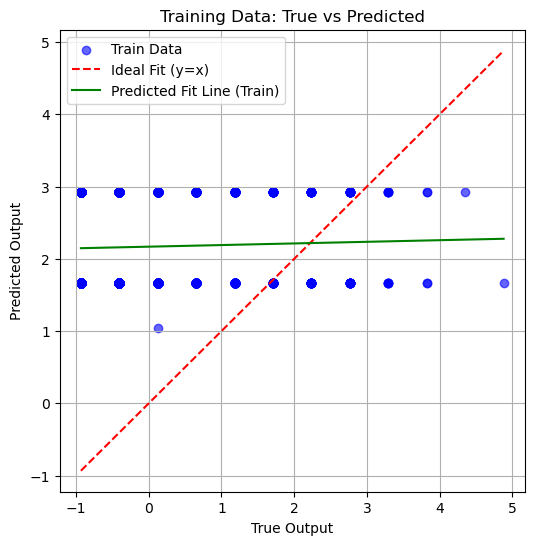

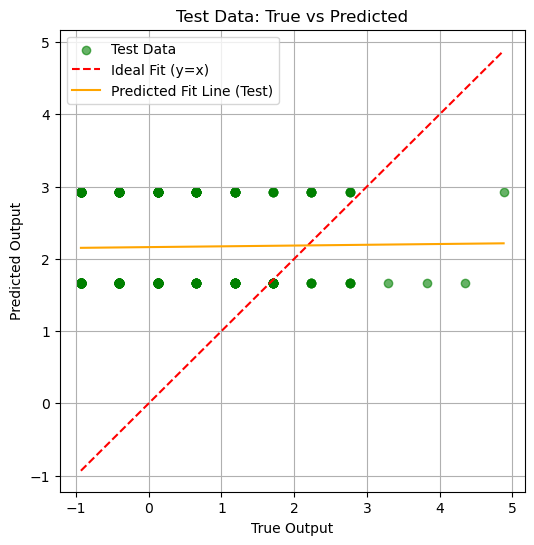

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Define the Multilayer Feedforward Neural Network (MLFFNN)
class MLFFNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):
        super(MLFFNN, self).__init__()
        
        # List to store layers
        layers = []
        
        # Input layer to the first hidden layer
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.Tanh())
        
        # Adding intermediate hidden layers
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            layers.append(nn.Tanh())
        
        # Output layer
        layers.append(nn.Linear(hidden_layers[-1], output_size))
        
        # Register the layers as a Sequential model
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Function to train the network and capture training loss
def train_model(model, criterion, optimizer, train_loader, epochs=100):
    model.train()
    losses = []  # To store loss for each epoch
    
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)  # Append loss for plotting
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')
    
    return losses  # Return losses for the training error vs. epoch plot

# Function to plot training error vs. epoch
def plot_training_error(losses):
    plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
    # Set line style, color, and marker options
    plt.plot(range(1, len(losses) + 1), losses, label='Training Error', color='blue', marker='o', linestyle='-', markersize=3, linewidth=1)
    plt.xlabel('Epoch')
    plt.ylabel('Training Error (६av)')
    plt.title('Training Error vs. Epoch')
    plt.grid(True)  # Add grid lines
    plt.legend()
    plt.show()

# Function to scatter plot predictions vs actual outputs for training and test data
# Function to scatter plot training and test data with predictions, regression line, and fit line
def scatter_plot_data(model, X_train, y_train, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train).detach().numpy()
        y_test_pred = model(X_test).detach().numpy()
    
    # Scatter plot for training data with regression line (y = x) and best-fit line
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train.flatten(), y_train_pred.flatten(), label='Train Data', color='blue', alpha=0.6)
    
    # Ideal fit line (y = x)
    min_val = min(y_train.min(), y_train_pred.min())  # Get the minimum value for the line
    max_val = max(y_train.max(), y_train_pred.max())  # Get the maximum value for the line
    plt.plot([min_val, max_val], [min_val, max_val], color='red', label='Ideal Fit (y=x)', linestyle='--')
    
    # Predicted fit line using polyfit (degree 1 for linear fit)
    slope, intercept = np.polyfit(y_train.flatten(), y_train_pred.flatten(), 1)
    y_pred_fit = slope * np.array([min_val, max_val]) + intercept
    plt.plot([min_val, max_val], y_pred_fit, color='green', label='Predicted Fit Line (Train)', linestyle='-')

    plt.xlabel('True Output')
    plt.ylabel('Predicted Output')
    plt.title('Training Data: True vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Scatter plot for test data with regression line (y = x) and best-fit line
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test.flatten(), y_test_pred.flatten(), label='Test Data', color='green', alpha=0.6)
    
    # Ideal fit line (y = x)
    min_val = min(y_test.min(), y_test_pred.min())  # Get the minimum value for the line
    max_val = max(y_test.max(), y_test_pred.max())  # Get the maximum value for the line
    plt.plot([min_val, max_val], [min_val, max_val], color='red', label='Ideal Fit (y=x)', linestyle='--')
    
    # Predicted fit line for test data using polyfit (degree 1 for linear fit)
    slope_test, intercept_test = np.polyfit(y_test.flatten(), y_test_pred.flatten(), 1)
    y_test_fit = slope_test * np.array([min_val, max_val]) + intercept_test
    plt.plot([min_val, max_val], y_test_fit, color='orange', label='Predicted Fit Line (Test)', linestyle='-')

    plt.xlabel('True Output')
    plt.ylabel('Predicted Output')
    plt.title('Test Data: True vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()


# Function to load and normalize the data from CSV files
def load_and_normalize_data(train_data_path, train_label_path, test_data_path, test_label_path):
    # Load the train and test data
    train_data = pd.read_csv(train_data_path, header=None)
    train_labels = pd.read_csv(train_label_path, header=None)
    
    test_data = pd.read_csv(test_data_path, header=None)
    test_labels = pd.read_csv(test_label_path, header=None)
    
    # Normalize input data using StandardScaler
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train = scaler_X.fit_transform(train_data.values)
    y_train = scaler_y.fit_transform(train_labels.values.reshape(-1, 1)).ravel()
    
    X_test = scaler_X.transform(test_data.values)
    y_test = scaler_y.transform(test_labels.values.reshape(-1, 1)).ravel()
    
    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make y 2D for MSE loss
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    
    # Print shapes for debugging
    print(f'X_train shape: {X_train_tensor.shape}, y_train shape: {y_train_tensor.shape}')
    print(f'X_test shape: {X_test_tensor.shape}, y_test shape: {y_test_tensor.shape}')
    
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor



# Hyperparameters
input_size = 3  # Number of features in your dataset
output_size = 1  # Single output (function approximation)
hidden_layers = [12,8]  # Example: 3 hidden layers with 10, 15, 10 nodes
learning_rate = 0.2

# Create the model
model = MLFFNN(input_size, output_size, hidden_layers)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for function approximation
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# File paths for your dataset
train_data_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D2_dataset3_1\train_data.csv"
train_label_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D2_dataset3_1\train_label.csv"
test_data_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D2_dataset3_1\test_data.csv"
test_label_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D2_dataset3_1\test_label.csv"

# Load and normalize the data
X_train, y_train, X_test, y_test = load_and_normalize_data(train_data_path, train_label_path, test_data_path, test_label_path)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Train the model
losses = train_model(model, criterion, optimizer, train_loader, epochs=100)

# Plot the training error vs. epoch
plot_training_error(losses)

# Scatter plot the predictions vs actual outputs for training and test data
scatter_plot_data(model, X_train, y_train, X_test, y_test)


X_train shape: torch.Size([1524, 3]), y_train shape: torch.Size([1524, 1])
X_test shape: torch.Size([436, 3]), y_test shape: torch.Size([436, 1])
Epoch [1/100], Loss: 2.465687
Epoch [2/100], Loss: 3.637266
Epoch [3/100], Loss: 8.832904
Epoch [4/100], Loss: 25.157990
Epoch [5/100], Loss: 19.192306
Epoch [6/100], Loss: 30.882951
Epoch [7/100], Loss: 21.162291
Epoch [8/100], Loss: 11.224807
Epoch [9/100], Loss: 30.644135
Epoch [10/100], Loss: 36.483493
Epoch [11/100], Loss: 37.104381
Epoch [12/100], Loss: 26.240781
Epoch [13/100], Loss: 17.113425
Epoch [14/100], Loss: 28.260531
Epoch [15/100], Loss: 8.915930
Epoch [16/100], Loss: 19.467146
Epoch [17/100], Loss: 30.553204
Epoch [18/100], Loss: 30.594824
Epoch [19/100], Loss: 42.382471
Epoch [20/100], Loss: 42.196646
Epoch [21/100], Loss: 12.868519
Epoch [22/100], Loss: 16.805763
Epoch [23/100], Loss: 40.888425
Epoch [24/100], Loss: 27.247150
Epoch [25/100], Loss: 19.958915
Epoch [26/100], Loss: 30.324137
Epoch [27/100], Loss: 12.832074
Epo

C:\Users\arist\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2412 (\N{DEVANAGARI DIGIT SIX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\arist\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


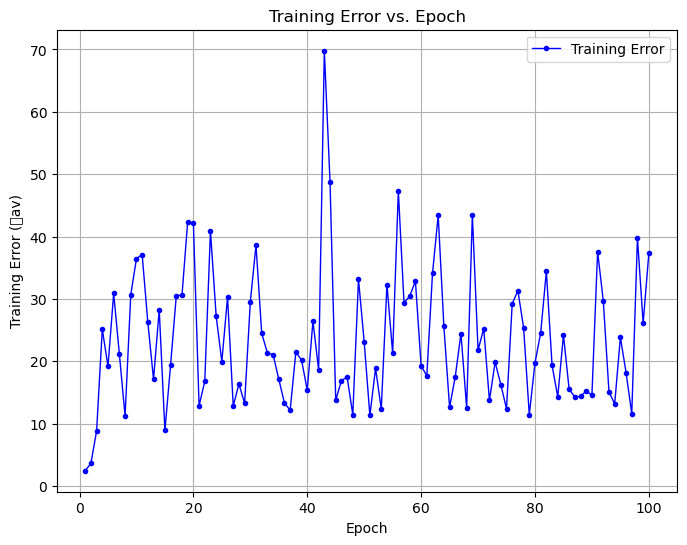

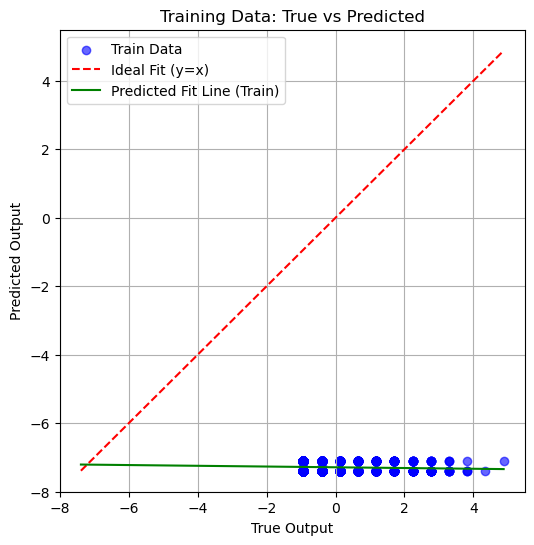

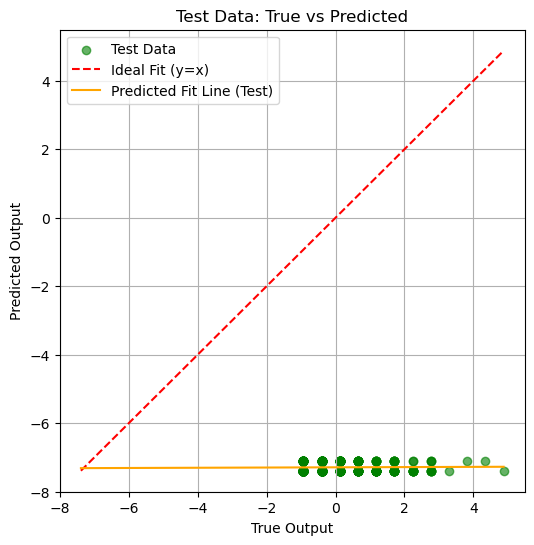

In [112]:

# Hyperparameters
# Hyperparameters
input_size = 3  # Two input features (x1, x2)
output_size = 1  # Single output (function approximation)
hidden_layers = [12,8]  # Example: 1 hidden layer with 8 nodes
learning_rate = 0.2

# Create the model
model = MLFFNN(input_size, output_size, hidden_layers)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for function approximation
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# File paths for your dataset
train_data_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D2_dataset3_1\train_data.csv"
train_label_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D2_dataset3_1\train_label.csv"
test_data_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D2_dataset3_1\test_data.csv"
test_label_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D2_dataset3_1\test_label.csv"

# Load and normalize the data
X_train, y_train, X_test, y_test = load_and_normalize_data(train_data_path, train_label_path, test_data_path, test_label_path)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Train the model
losses = train_model(model, criterion, optimizer, train_loader, epochs=100)

# Plot the training error vs. epoch
plot_training_error(losses)

# Scatter plot the training and test data with predictions
scatter_plot_data(model, X_train, y_train, X_test, y_test)



# Dataset 3

C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


GMM with Full Covariance - Training Accuracy: 1.00, Test Accuracy: 1.00
Training Confusion Matrix:
[[572   0]
 [  0 551]]
Test Confusion Matrix:
[[78  0]
 [ 0 82]]


C:\Users\arist\AppData\Local\Temp\ipykernel_21000\4016275113.py:65: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


GMM with Diagonal Covariance - Training Accuracy: 1.00, Test Accuracy: 1.00
Training Confusion Matrix:
[[572   0]
 [  0 551]]
Test Confusion Matrix:
[[78  0]
 [ 0 82]]


C:\Users\arist\AppData\Local\Temp\ipykernel_21000\4016275113.py:65: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
C:\Users\arist\AppData\Local\Temp\ipykernel_21000\4016275113.py:65: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
C:\Users\arist\AppData\Local\Temp\ipykernel_21000\4016275113.py:65: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


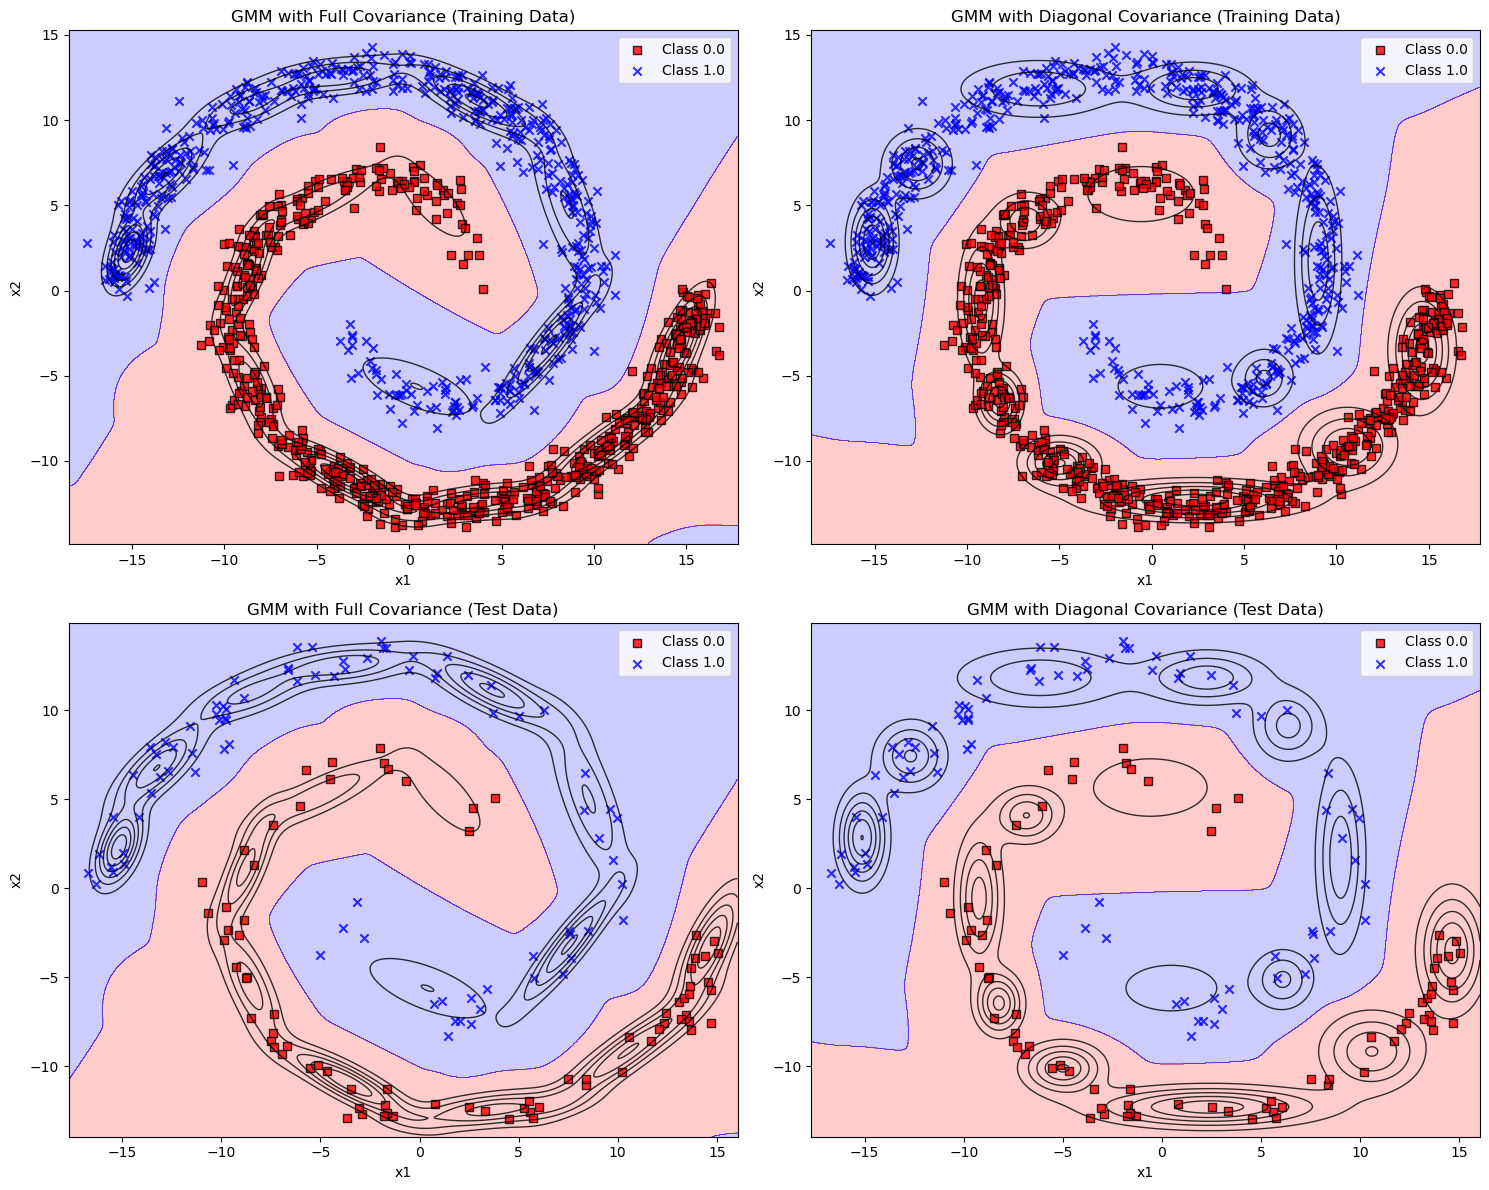


Accuracy Table:
Empty DataFrame
Columns: [Model, Training Accuracy, Test Accuracy]
Index: []


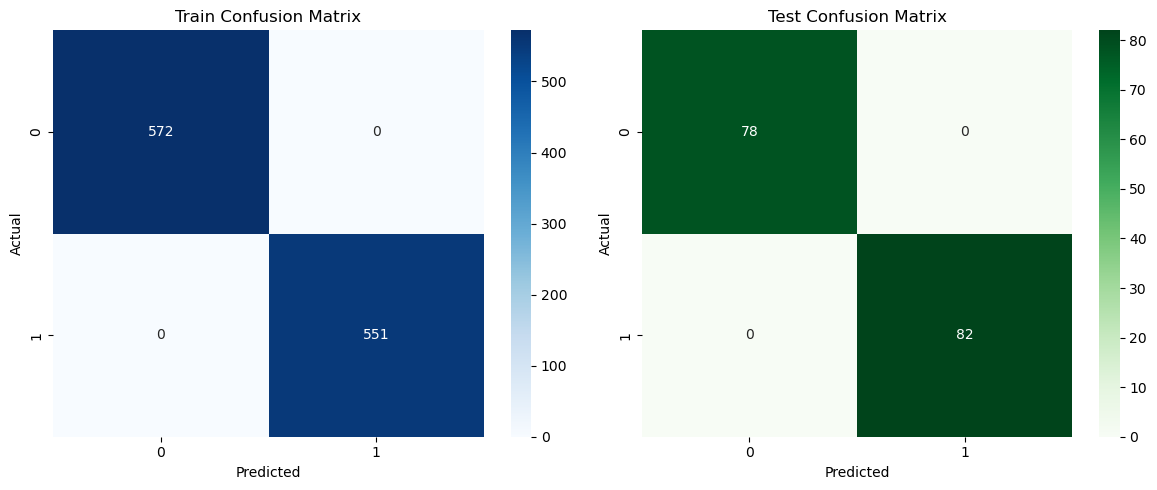

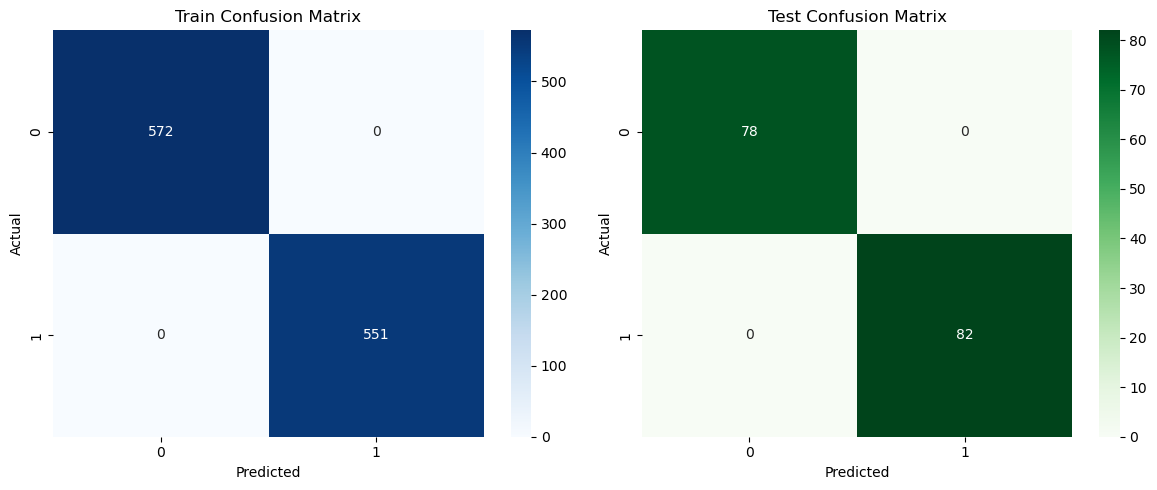

In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap

# GMM Classifier wrapper
class GMMClassifier:
    def __init__(self, n_components, covariance_type='full'):  # Corrected to __init_
        self.gmms = []
        self.n_components = n_components
        self.covariance_type = covariance_type

    def fit(self, X, y):
        self.gmms = []
        self.classes_ = np.unique(y)
        for cl in self.classes_:
            gmm = GaussianMixture(n_components=self.n_components, covariance_type=self.covariance_type)
            gmm.fit(X[y == cl])
            self.gmms.append(gmm)

    def predict(self, X):
        likelihood = np.array([gmm.score_samples(X) for gmm in self.gmms]).T
        return self.classes_[np.argmax(likelihood, axis=1)]


# Load the datasets
train_data = pd.read_csv(r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D3_Dataset2_2\Train.csv")
test_data = pd.read_csv(r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D3_Dataset2_2\Test.csv")

# Split into inputs (X) and labels (y)
X_train = train_data[['x1', 'x2']].values
y_train = train_data['label'].values

X_test = test_data[['x1', 'x2']].values
y_test = test_data['label'].values

# Helper function to plot decision regions
def plot_decision_regions(X, y, classifier, title, ax, resolution=0.02):
    # Setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)  # Adjusted alpha for decision surface

    # Plot level curves for each class with increased visibility
    for i, gmm in enumerate(classifier.gmms):
        Z_density = np.exp(gmm.score_samples(np.array([xx1.ravel(), xx2.ravel()]).T))
        Z_density = Z_density.reshape(xx1.shape)
        # Increase the number of levels and make them more distinct
        ax.contour(xx1, xx2, Z_density, levels=6, colors='black', linewidths=1, alpha=0.8)  # Adjusted alpha and line width

    # Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                   alpha=0.8, c=colors[idx],
                   marker=markers[idx], label=f'Class {cl}', edgecolor='black')

    ax.set_title(title)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.legend()

# Evaluation function
def evaluate_classifier(X_train, y_train, X_test, y_test, classifier, title, ax):
    # Fit and predict for training data
    classifier.fit(X_train, y_train)
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f'{title} - Training Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}')

    # Training confusion matrix
    train_cm = confusion_matrix(y_train, y_train_pred)
    print('Training Confusion Matrix:')
    print(train_cm)

    # Test confusion matrix
    test_cm = confusion_matrix(y_test, y_test_pred)
    print('Test Confusion Matrix:')
    print(test_cm)

    # Plot decision regions for training data
    plot_decision_regions(X_train, y_train, classifier, f'{title} (Training Data)', ax)

    return train_accuracy, test_accuracy, train_cm, test_cm

# Initialize classifiers and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Create a list to store accuracies and confusion matrices
results = []
# GMM Classifier with Full Covariance
gmm_full = GMMClassifier(n_components=8, covariance_type='full')
train_acc_full, test_acc_full, train_cm_full, test_cm_full = evaluate_classifier(X_train, y_train, X_test, y_test, gmm_full, 'GMM with Full Covariance', axs[0, 0])

# GMM Classifier with Diagonal Covariance
gmm_diag = GMMClassifier(n_components=8, covariance_type='diag')
train_acc_diag, test_acc_diag, train_cm_diag, test_cm_diag = evaluate_classifier(X_train, y_train, X_test, y_test, gmm_diag, 'GMM with Diagonal Covariance', axs[0, 1])

# Plot decision regions for test data
plot_decision_regions(X_test, y_test, gmm_full, 'GMM with Full Covariance (Test Data)', axs[1, 0])
plot_decision_regions(X_test, y_test, gmm_diag, 'GMM with Diagonal Covariance (Test Data)', axs[1, 1])

plt.tight_layout()
plt.show()

# Create a DataFrame for accuracies and display it as a table
accuracy_df = pd.DataFrame(results, columns=['Model', 'Training Accuracy', 'Test Accuracy'])
print("\nAccuracy Table:")
print(accuracy_df)

# Plot confusion matrices using heatmaps
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(train_cm_full, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title('Train Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(test_cm_full, annot=True, fmt="d", cmap="Greens", ax=ax[1])
ax[1].set_title('Test Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Plot confusion matrices for diagonal covariance
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(train_cm_diag, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title('Train Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(test_cm_diag, annot=True, fmt="d", cmap="Greens", ax=ax[1])
ax[1].set_title('Test Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [261]:
## Dataset 4

C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

Training Accuracy: 0.9223809523809524
Test Accuracy: 0.57


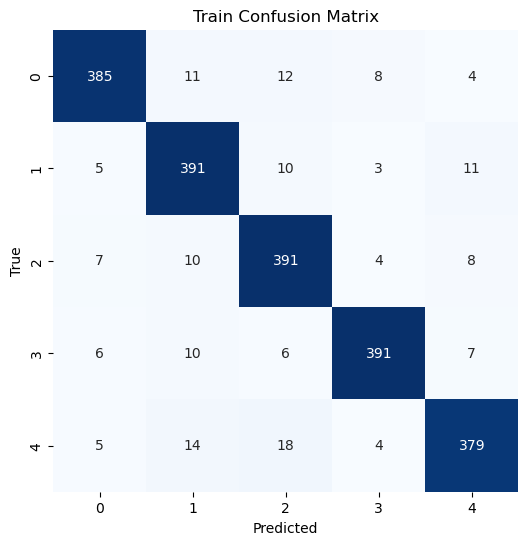

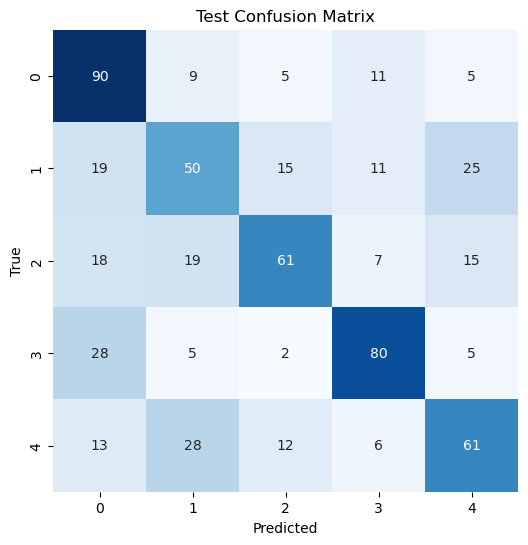

In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# GMM-based classifier
def gmm_classifier(train_data, train_labels, test_data, test_labels, g, covariance_type='full'):
    # Initialize GMMs for each class
    classes = np.unique(train_labels)
    gmms = {}

    for cls in classes:
        # Fit a GMM with g components for each class
        gmm = GaussianMixture(n_components=g, covariance_type=covariance_type, random_state=42)
        gmm.fit(train_data[train_labels == cls])
        gmms[cls] = gmm

    # Predict for both training and test data
    train_predictions = predict_gmm(gmms, train_data, classes)
    test_predictions = predict_gmm(gmms, test_data, classes)

    # Confusion matrices and accuracies
    train_conf_matrix = confusion_matrix(train_labels, train_predictions)
    test_conf_matrix = confusion_matrix(test_labels, test_predictions)

    train_accuracy = accuracy_score(train_labels, train_predictions)
    test_accuracy = accuracy_score(test_labels, test_predictions)

    return gmms, train_predictions, test_predictions, train_conf_matrix, test_conf_matrix, train_accuracy, test_accuracy

# Function to predict using GMMs
def predict_gmm(gmms, data, classes):
    probs = []
    for cls in classes:
        # Compute the log likelihood for each class's GMM
        log_likelihood = gmms[cls].score_samples(data)
        probs.append(log_likelihood)
    
    # Stack and get the class with the maximum likelihood
    probs = np.stack(probs, axis=1)
    return classes[np.argmax(probs, axis=1)]

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


# File paths for your dataset
train_data_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D4_Dataset3_2\train_data.csv"
train_label_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D4_Dataset3_2\train_label.csv"
test_data_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D4_Dataset3_2\test_data.csv"
test_label_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D4_Dataset3_2\test_label.csv"

# Load and normalize the data
def load_and_normalize_data(train_data_path, train_label_path, test_data_path, test_label_path):
    # Load the train and test data
    train_data = pd.read_csv(train_data_path, header=None)
    train_labels = pd.read_csv(train_label_path, header=None).values.ravel()
    
    test_data = pd.read_csv(test_data_path, header=None)
    test_labels = pd.read_csv(test_label_path, header=None).values.ravel()
    
    # Normalize input data using StandardScaler
    scaler_X = StandardScaler()
    
    X_train = scaler_X.fit_transform(train_data.values)
    X_test = scaler_X.transform(test_data.values)
    
    return X_train, train_labels, X_test, test_labels

# Load and normalize data
train_data, train_labels, test_data, test_labels = load_and_normalize_data(train_data_path, train_label_path, test_data_path, test_label_path)

# Number of Gaussian components
g = 3  

# Fit GMM and predict
gmms, gmm_full_train_predictions, gmm_full_test_predictions, train_cm, test_cm, train_acc, test_acc = gmm_classifier(train_data, train_labels, test_data, test_labels, g, covariance_type='full')

# Print accuracy
print(f"Training Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

# Plot confusion matrices
plot_confusion_matrix(train_cm, title='Train Confusion Matrix')
plot_confusion_matrix(test_cm, title='Test Confusion Matrix')

C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

Training Accuracy: 0.6309523809523809
Test Accuracy: 0.5783333333333334


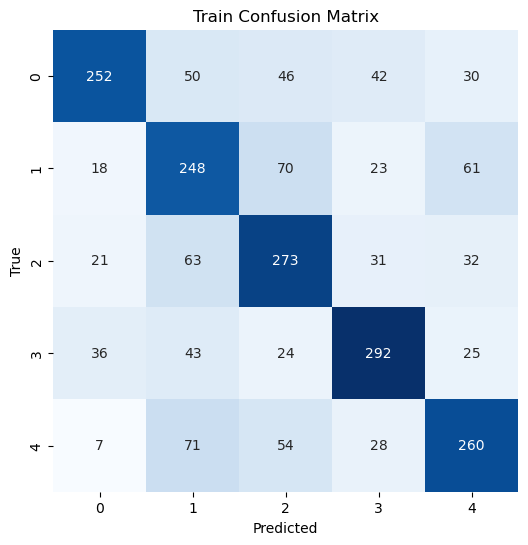

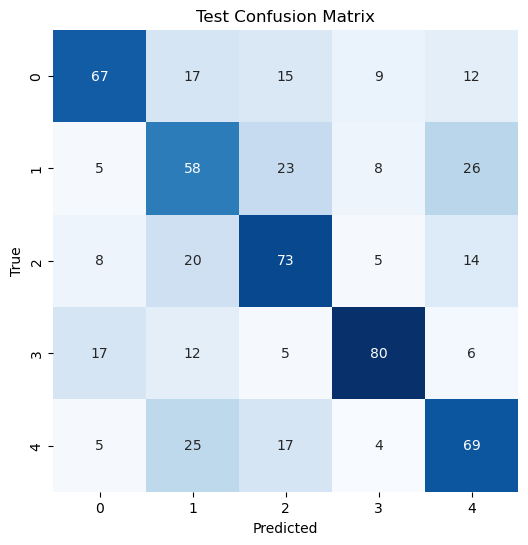

In [277]:
# Load and normalize data
train_data, train_labels, test_data, test_labels = load_and_normalize_data(train_data_path, train_label_path, test_data_path, test_label_path)

# Number of Gaussian components
g = 3  

# Fit GMM and predict
gmms, gmm_full_train_predictions, gmm_full_test_predictions, train_cm, test_cm, train_acc, test_acc = gmm_classifier(train_data, train_labels, test_data, test_labels, g, covariance_type='diag')

# Print accuracy
print(f"Training Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

# Plot confusion matrices
plot_confusion_matrix(train_cm, title='Train Confusion Matrix')
plot_confusion_matrix(test_cm, title='Test Confusion Matrix')

C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\arist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

Training Accuracy: 0.9223809523809524
Test Accuracy: 0.57


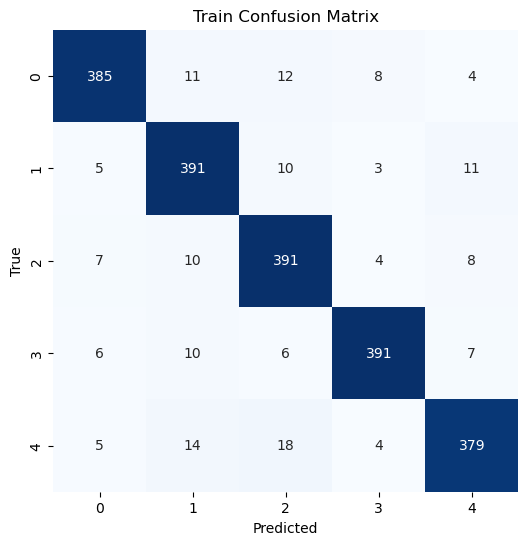

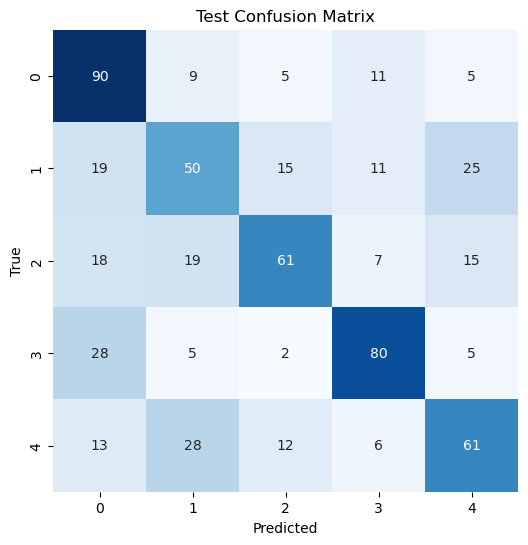

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# GMM-based classifier
def gmm_classifier(train_data, train_labels, test_data, test_labels, g, covariance_type='full'):
    # Initialize GMMs for each class
    classes = np.unique(train_labels)
    gmms = {}

    for cls in classes:
        # Fit a GMM with g components for each class
        gmm = GaussianMixture(n_components=g, covariance_type=covariance_type, random_state=42)
        gmm.fit(train_data[train_labels == cls])
        gmms[cls] = gmm

    # Predict for both training and test data
    train_predictions = predict_gmm(gmms, train_data, classes)
    test_predictions = predict_gmm(gmms, test_data, classes)

    # Confusion matrices and accuracies
    train_conf_matrix = confusion_matrix(train_labels, train_predictions)
    test_conf_matrix = confusion_matrix(test_labels, test_predictions)

    train_accuracy = accuracy_score(train_labels, train_predictions)
    test_accuracy = accuracy_score(test_labels, test_predictions)

    return gmms, train_predictions, test_predictions, train_conf_matrix, test_conf_matrix, train_accuracy, test_accuracy

# Function to predict using GMMs
def predict_gmm(gmms, data, classes):
    probs = []
    for cls in classes:
        # Compute the log likelihood for each class's GMM
        log_likelihood = gmms[cls].score_samples(data)
        probs.append(log_likelihood)
    
    # Stack and get the class with the maximum likelihood
    probs = np.stack(probs, axis=1)
    return classes[np.argmax(probs, axis=1)]

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


# File paths for your dataset
train_data_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D4_Dataset3_2\train_data.csv"
train_label_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D4_Dataset3_2\train_label.csv"
test_data_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D4_Dataset3_2\test_data.csv"
test_label_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D4_Dataset3_2\test_label.csv"

# Load and normalize the data
def load_and_normalize_data(train_data_path, train_label_path, test_data_path, test_label_path):
    # Load the train and test data
    train_data = pd.read_csv(train_data_path, header=None)
    train_labels = pd.read_csv(train_label_path, header=None).values.ravel()
    
    test_data = pd.read_csv(test_data_path, header=None)
    test_labels = pd.read_csv(test_label_path, header=None).values.ravel()
    
    # Normalize input data using StandardScaler
    scaler_X = StandardScaler()
    
    X_train = scaler_X.fit_transform(train_data.values)
    X_test = scaler_X.transform(test_data.values)
    
    return X_train, train_labels, X_test, test_labels

# Load and normalize data
train_data, train_labels, test_data, test_labels = load_and_normalize_data(train_data_path, train_label_path, test_data_path, test_label_path)

# Number of Gaussian components
g = 3  

# Fit GMM and predict
gmms, gmm_full_train_predictions, gmm_full_test_predictions, train_cm, test_cm, train_acc, test_acc = gmm_classifier(train_data, train_labels, test_data, test_labels, g, covariance_type='full')

# Print accuracy
print(f"Training Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

# Plot confusion matrices
plot_confusion_matrix(train_cm, title='Train Confusion Matrix')
plot_confusion_matrix(test_cm, title='Test Confusion Matrix')

## Dataset 3 MLFFNN

In [283]:
# Function to load and normalize the data from CSV files
def load_and_normalize_data(train_data_path, train_label_path, test_data_path, test_label_path):
    # Load the train and test data
    train_data = pd.read_csv(train_data_path, header=None)
    train_labels = pd.read_csv(train_label_path, header=None)
    
    test_data = pd.read_csv(test_data_path, header=None)
    test_labels = pd.read_csv(test_label_path, header=None)
    
    # Normalize input data using StandardScaler
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train = scaler_X.fit_transform(train_data.values)
    y_train = scaler_y.fit_transform(train_labels.values.reshape(-1, 1)).ravel()
    
    X_test = scaler_X.transform(test_data.values)
    y_test = scaler_y.transform(test_labels.values.reshape(-1, 1)).ravel()
    
    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make y 2D for MSE loss
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    
    # Print shapes for debugging
    print(f'X_train shape: {X_train_tensor.shape}, y_train shape: {y_train_tensor.shape}')
    print(f'X_test shape: {X_test_tensor.shape}, y_test shape: {y_test_tensor.shape}')
    
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

Epoch [1/100], Loss: 0.570943
Epoch [2/100], Loss: 0.519890
Epoch [3/100], Loss: 0.503447
Epoch [4/100], Loss: 0.497887
Epoch [5/100], Loss: 0.524216
Epoch [6/100], Loss: 0.471575
Epoch [7/100], Loss: 0.489007
Epoch [8/100], Loss: 0.444965
Epoch [9/100], Loss: 0.452541
Epoch [10/100], Loss: 0.491911
Epoch [11/100], Loss: 0.432170
Epoch [12/100], Loss: 0.486127
Epoch [13/100], Loss: 0.397942
Epoch [14/100], Loss: 0.406624
Epoch [15/100], Loss: 0.372543
Epoch [16/100], Loss: 0.397781
Epoch [17/100], Loss: 0.381319
Epoch [18/100], Loss: 0.368777
Epoch [19/100], Loss: 0.420311
Epoch [20/100], Loss: 0.395915
Epoch [21/100], Loss: 0.374035
Epoch [22/100], Loss: 0.348735
Epoch [23/100], Loss: 0.300996
Epoch [24/100], Loss: 0.348533
Epoch [25/100], Loss: 0.282353
Epoch [26/100], Loss: 0.579920
Epoch [27/100], Loss: 0.329260
Epoch [28/100], Loss: 0.386573
Epoch [29/100], Loss: 0.379691
Epoch [30/100], Loss: 0.260148
Epoch [31/100], Loss: 0.267258
Epoch [32/100], Loss: 0.301228
Epoch [33/100], L

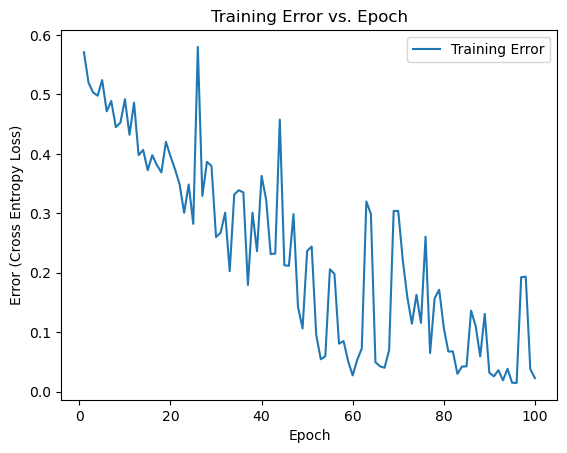

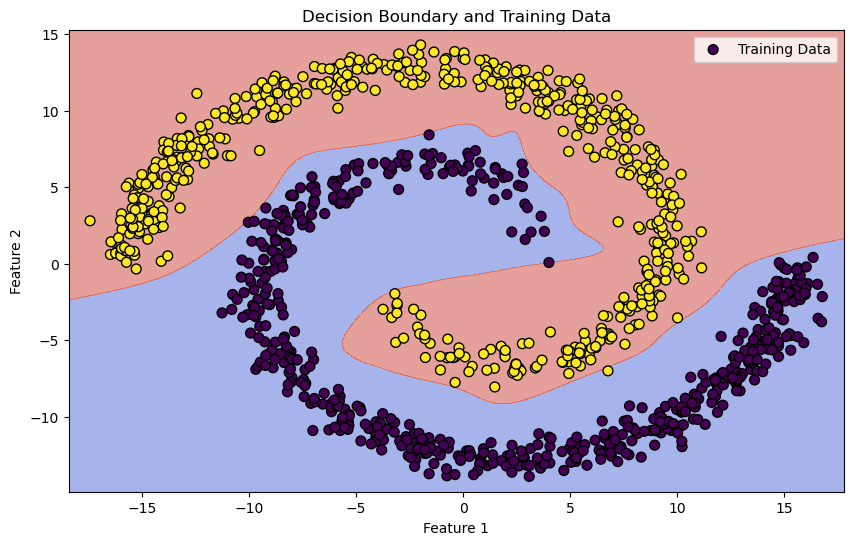

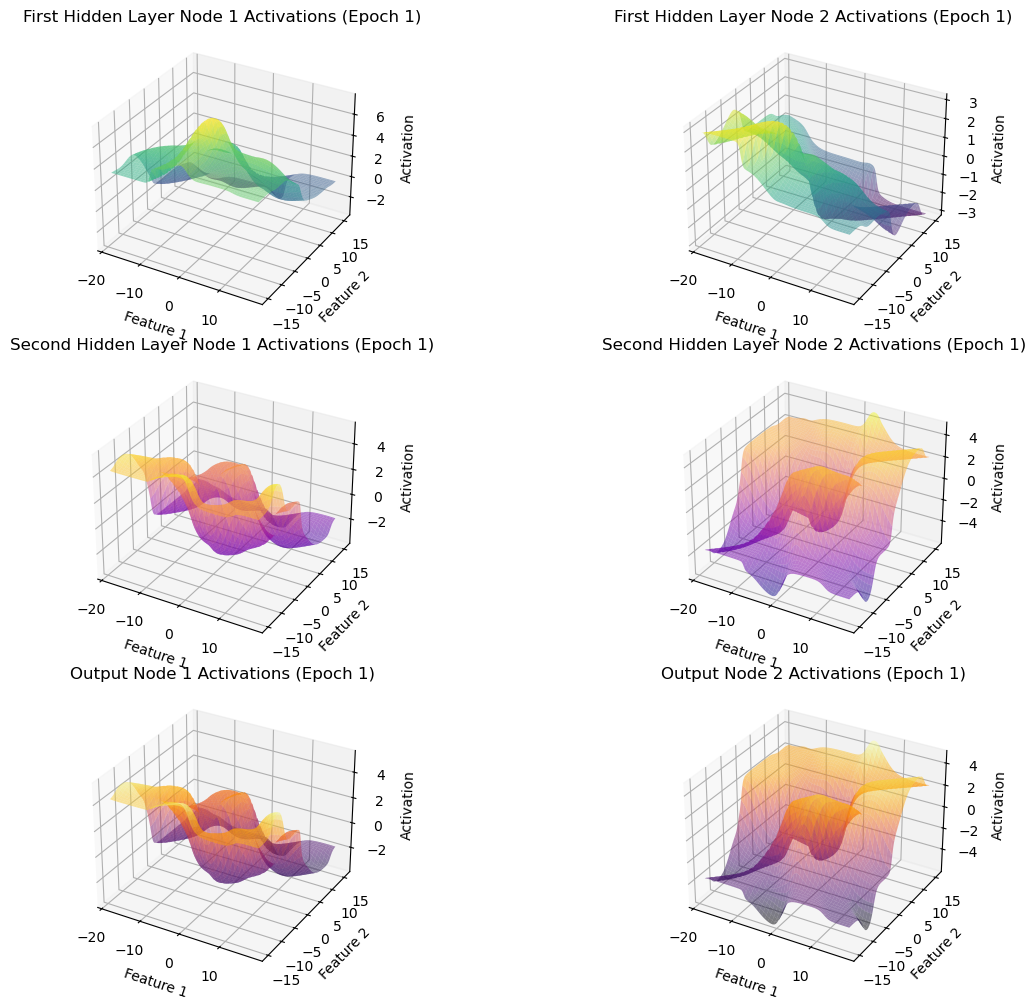

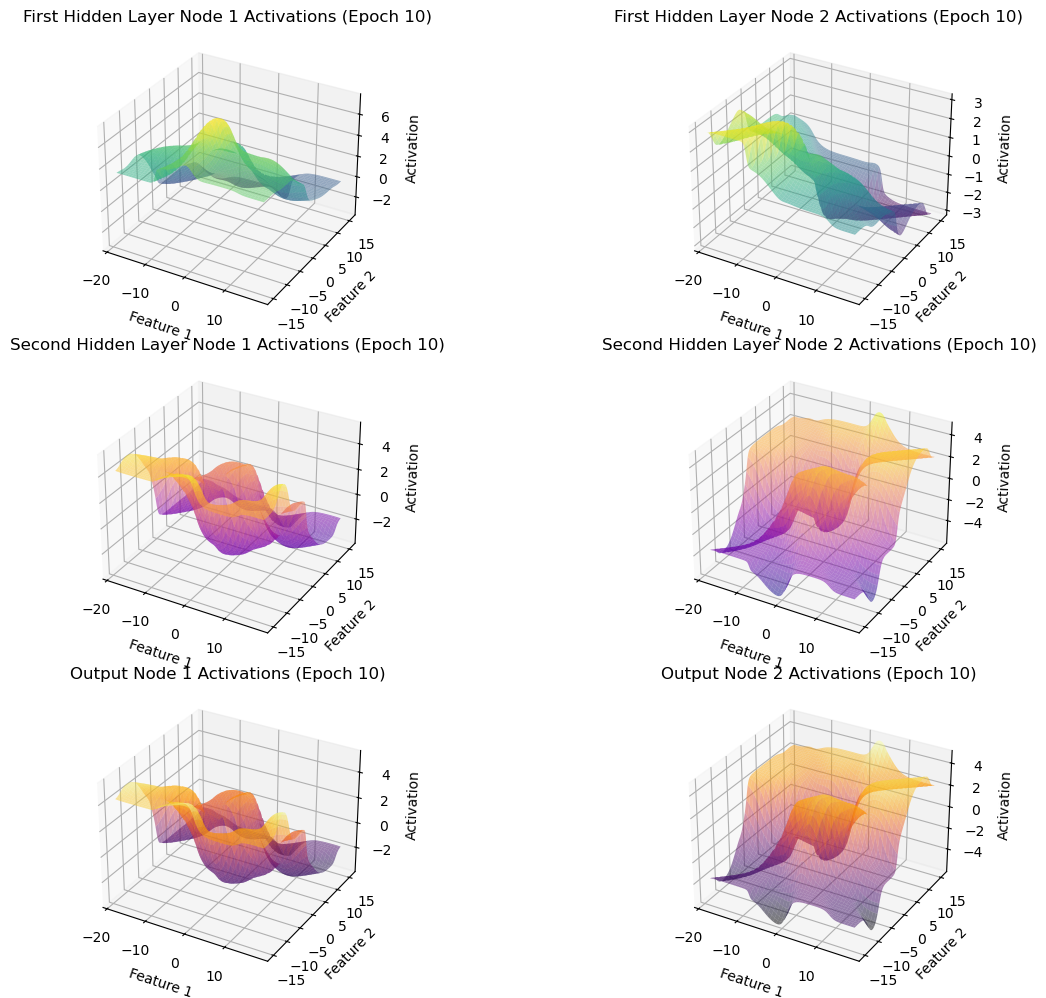

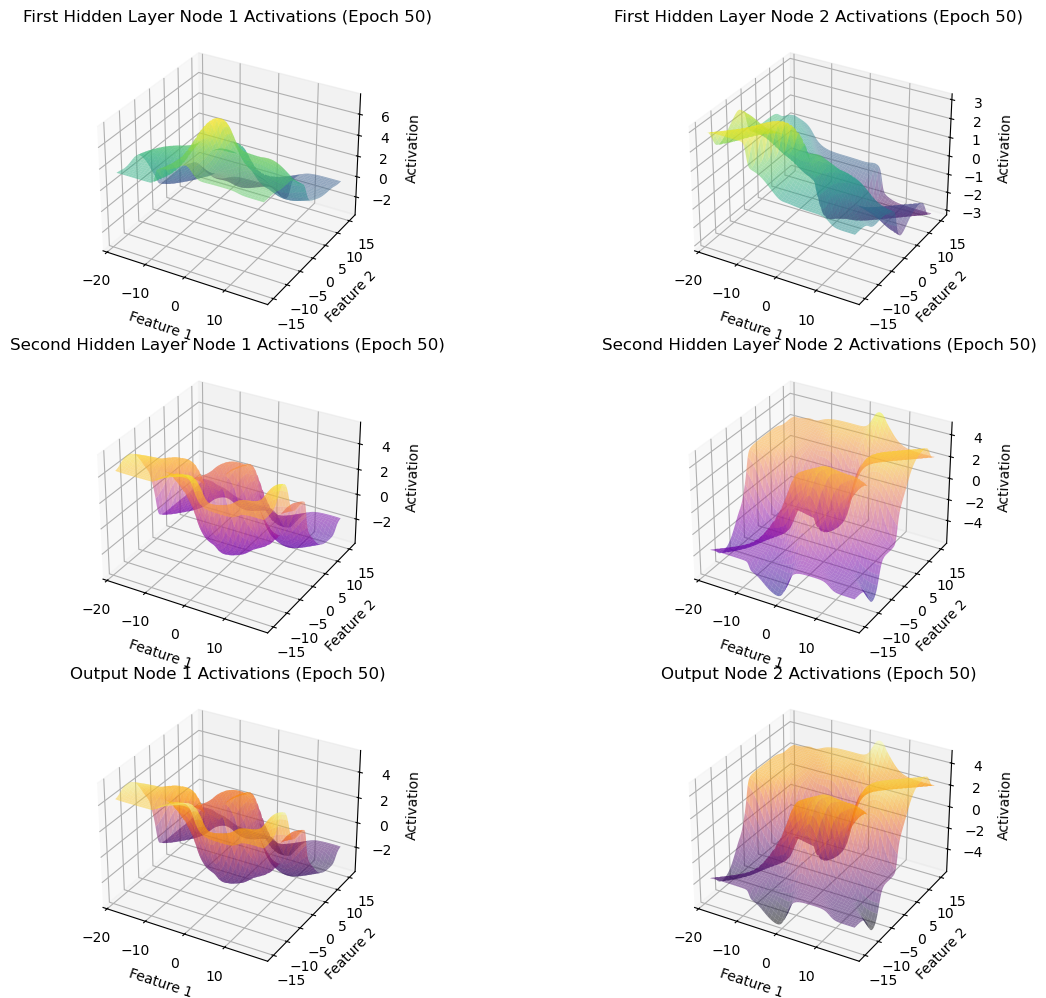

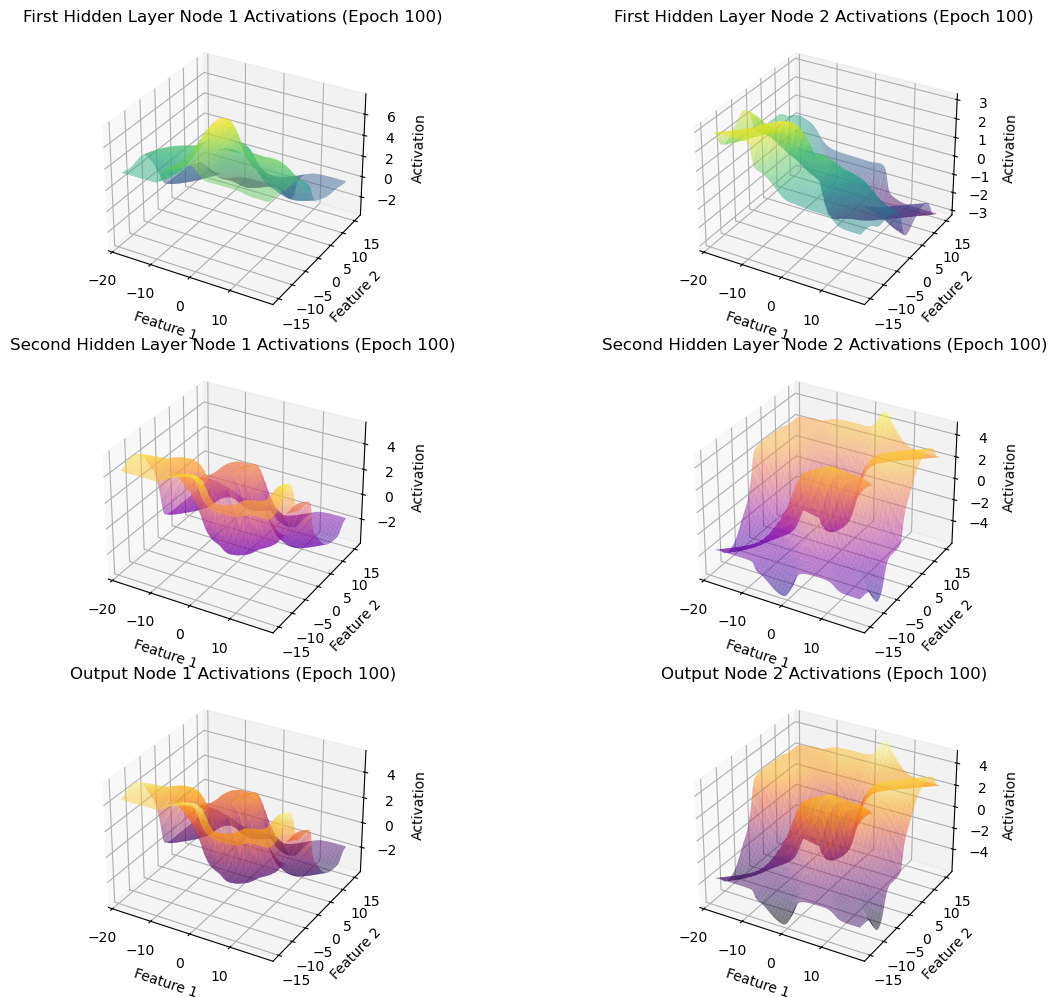

In [271]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # For 3D surface plots
from matplotlib import cm

# Load data from .csv file
def load_data(train_file_path, test_file_path):
    # Load the training data
    train_df = pd.read_csv(train_file_path)
    train_data = train_df.iloc[:, :-1].values  # Features (all columns except the last one)
    train_labels = train_df.iloc[:, -1].values  # Labels (last column)

    # Load the test data
    test_df = pd.read_csv(test_file_path)
    test_data = test_df.iloc[:, :-1].values  # Features
    test_labels = test_df.iloc[:, -1].values  # Labels

    # Convert to PyTorch tensors
    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)  # Change to long for classification

    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)  # Change to long for classification

    return train_data, train_labels, test_data, test_labels

# Define the Multilayer Feedforward Neural Network (MLFFNN) for classification
class MLFFNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):
        super(MLFFNN, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.Tanh())
        
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            layers.append(nn.Tanh())
        
        # Output layer with Softmax activation for classification
        layers.append(nn.Linear(hidden_layers[-1], output_size))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Function to train the network and capture training loss
def train_model(model, criterion, optimizer, train_loader, epochs=100):
    model.train()
    losses = []  # To store loss for each epoch
    
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)  # Append loss for plotting
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')
    
    return losses  # Return losses for the training error vs. epoch plot

# Function to plot training error vs. epoch
def plot_training_error(losses):
    plt.figure()
    plt.plot(range(1, len(losses) + 1), losses, label='Training Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error (Cross Entropy Loss)')
    plt.title('Training Error vs. Epoch')
    plt.legend()
    plt.show()

# Function to plot decision regions
def plot_decision_regions(model, X_train, y_train):
    model.eval()
    
    # Create a mesh grid for the feature space
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Prepare input for the model
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    
    # Get predictions for the grid
    with torch.no_grad():
        Z = model(grid).argmax(dim=1).detach().numpy()
    
    # Reshape Z to match the mesh grid
    Z = Z.reshape(xx.shape)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=cm.coolwarm)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', marker='o', s=50, label='Training Data')
    plt.title('Decision Boundary and Training Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# Function to plot surface plots for hidden and output layers
def plot_surface(model, epoch, input_data):
    model.eval()
    
    # Create a mesh grid for the feature space
    x_min, x_max = input_data[:, 0].min() - 1, input_data[:, 0].max() + 1
    y_min, y_max = input_data[:, 1].min() - 1, input_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Prepare input for the model
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)  # Ensure it has the right shape
    
    # Get outputs for the grid
    with torch.no_grad():
        hidden1 = model.network[0:3](grid)  # First hidden layer activations
        # Check if there's a second hidden layer before accessing
        if len(hidden_layers) > 1:
            hidden2 = model.network[3:6](hidden1)  # Second hidden layer activations
        else:
            hidden2 = hidden1  # If there's no second hidden layer, use the first as output
        
        output = model(grid)  # Output layer activations
    
    # Plotting activations of the hidden nodes
    fig = plt.figure(figsize=(15, 10))
    
    # Plot first 2 nodes from the first hidden layer
    for i in range(min(2, hidden1.shape[1])):  # Adjust to the number of nodes present
        ax = fig.add_subplot(3, 2, i + 1, projection='3d')
        ax.plot_surface(xx, yy, hidden1[:, i].reshape(xx.shape).numpy(), cmap=cm.viridis, alpha=0.5)
        ax.set_title(f'First Hidden Layer Node {i + 1} Activations (Epoch {epoch})')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Activation')

    # Plot first 2 nodes from the second hidden layer, if it exists
    for i in range(min(2, hidden2.shape[1])):  # Adjust to the number of nodes present
        ax = fig.add_subplot(3, 2, i + 3, projection='3d')
        ax.plot_surface(xx, yy, hidden2[:, i].reshape(xx.shape).numpy(), cmap=cm.plasma, alpha=0.5)
        ax.set_title(f'Second Hidden Layer Node {i + 1} Activations (Epoch {epoch})')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Activation')

    # Plot all output nodes
    for i in range(output.shape[1]):
        ax = fig.add_subplot(3, 2, i + 5, projection='3d')
        output_z = output[:, i].reshape(xx.shape).numpy()
        ax.plot_surface(xx, yy, output_z, cmap=cm.inferno, alpha=0.5)
        ax.set_title(f'Output Node {i + 1} Activations (Epoch {epoch})')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Activation')
    
    plt.tight_layout()
    plt.show()

# Hyperparameters
train_file_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D3_Dataset2_2\Train.csv"
test_file_path = r"C:\Users\arist\Desktop\Quantum\My Books\IITM\1st Sem\Machine Leearning\project3ML\D3_Dataset2_2\Test.csv"

# Load data
train_data, train_labels, test_data, test_labels = load_data(train_file_path, test_file_path)

input_size = train_data.shape[1]  # Number of features
output_size = len(np.unique(train_labels))  # Number of classes

hidden_layers = [12, 8]  # Example: 1 hidden layer with 8 nodes
learning_rate = 0.1
epochs = 100

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)

# Create model, define criterion and optimizer
model = MLFFNN(input_size, output_size, hidden_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
losses = train_model(model, criterion, optimizer, train_loader, epochs)

# Plot training error
plot_training_error(losses)

# Decision region plot
plot_decision_regions(model, train_data.numpy(), train_labels.numpy())

# Surface plots after specified epochs
for epoch in [1, 10, 50, 100]:
    plot_surface(model, epoch, train_data.numpy())

In [273]:

# Hyperparameters
train_file_path = r"C:\Users\deben\OneDrive\Desktop\IITM\PRML\Assignment\Assignment 3\Dataset-3_\Train.csv"
test_file_path = r"C:\Users\deben\OneDrive\Desktop\IITM\PRML\Assignment\Assignment 3\Dataset-3_\Test.csv"

# Load data
train_data, train_labels, test_data, test_labels = load_data(train_file_path, test_file_path)

input_size = train_data.shape[1]  # Number of features
output_size = len(np.unique(train_labels))  # Number of classes

hidden_layers = [12,8]  # Example: 1 hidden layer with 8 nodes
learning_rate = 0.1

# Create the model
model = MLFFNN(input_size, output_size, hidden_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross Entropy Loss for classification
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Create DataLoader for batch processing
train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Train the model
losses = train_model(model, criterion, optimizer, train_loader, epochs=100)

# Plot the training error vs. epoch
plot_training_error(losses)

# Plot decision regions
plot_decision_regions(model, train_data.numpy(), train_labels.numpy())

# Surface plots for hidden and output layers after epochs 1, 10, 50, and convergence
for epoch in [1, 10, 50, 100]:
    plot_surface(model, epoch, train_data.numpy())

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\deben\\OneDrive\\Desktop\\IITM\\PRML\\Assignment\\Assignment 3\\Dataset-3_\\Train.csv'